# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão
- [ ] Checar quebra estrutural em 1991

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.pdf
Benchmark.ipynb		tabs			VECM_Infla.py
Benchmark.pdf		tese_Lucas.xls		VECM_TxPropria.html
Benchmark.Rmd		Teste.ipynb		VECM_TxPropria.ipynb
Clean-checkpoint.ipynb	VECM_Infla.html		VECM_TxPropria_media.ipynb
Clean.ipynb		VECM_Infla.ipynb	VECM_TxPropria.pdf
figs			VECM_Infla_media.ipynb	VECM_TxPropria.py


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

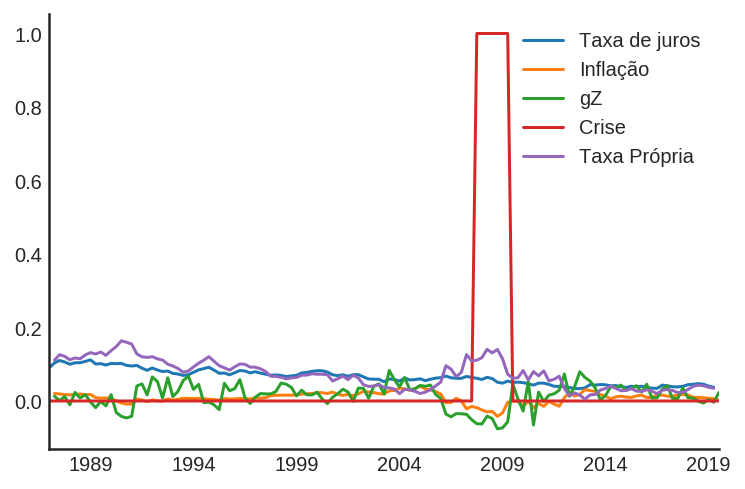

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
1987-09-30,0.1102,0.018975,0.001110,0,0.126023,0.015103,-0.011713,-0.001516,0.0067
1987-12-31,0.1061,0.017537,0.011925,0,0.121337,-0.004686,0.010815,-0.001437,-0.0041
1988-03-31,0.0999,0.016549,-0.010302,0,0.112091,-0.009246,-0.022228,-0.000988,-0.0062
1988-06-30,0.1040,0.017773,0.023392,0,0.117053,0.004961,0.033694,0.001224,0.0041
1988-09-30,0.1042,0.019099,0.007998,0,0.114831,-0.002222,-0.015394,0.001326,0.0002


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('M').last()
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df = df.resample('Q').last()

df["Inflação"] = df["Preço dos imóveis"].pct_change() # Warning: 4
df['gZ'] = df["Investimento residencial"].pct_change() # Warning: 4
df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1

df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])
#df['Inflação'], *_ = yeojohnson(df['Inflação'])
df['gZ'], *_ = yeojohnson(df['gZ'])

df[["Inflação", "gZ", "Taxa Própria", "Taxa de juros"]].to_csv("Dados_completos.csv")

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.head()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=6, signif = 0.05,):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=signif,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        print("Teste SEM constante")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=-1, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print("\nTeste COM constante\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=0, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print("\nTeste COM constante E tendência\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1]
    conclusion = result < signif
    for j in range(k):
      print(f'p-value = {result[j]}')
      print("Reject H0 on lag " ,j+1,"? ", conclusion[j], "\n")
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    sns.set_context('paper')
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 1)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 1)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')
    
    return fig

# Teste de quebra estrutural

In [8]:
%%R
library(strucchange)
library(urca)
library(dplyr)

df <- read.csv(
  "/dados/Dissertacao/Modelo/SeriesTemporais/Dados_completos.csv",
  encoding="UTF-8", 
  stringsAsFactors=FALSE
  )
df <- ts(data = df, start = c(1987,01), frequency = 4)
df <- zoo::na.locf0(df)
colnames(df) <- c("X", "Infla", "gZ", "TaxaP", "Juros")

## Taxa de crescimento do investimento residencial


result = breakpoints(gZ~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(gZ~1, data=df, point=i, type="Chow") %>% print()
}


## Taxa Própria


result = breakpoints(TaxaP~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(TaxaP~1, data=df, point=i, type="Chow") %>% print()
}


## Taxa de juros


result = breakpoints(Juros~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(Juros~1, data=df, point=i, type="Chow") %>% print()
}


## Inflação


result = breakpoints(Infla~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(Infla~1, data=df, point=i, type="Chow") %>% print()
}

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Testando para i = 1991.5"

	Chow test

data:  gZ ~ 1
F = 5.1147, p-value = 0.0254

[1] "Testando para i = 2005.75"

	Chow test

data:  gZ ~ 1
F = 7.286, p-value = 0.007881

[1] "Testando para i = 2010.5"

	Chow test

data:  gZ ~ 1
F = 6.1013, p-value = 0.01481

[1] "Testando para i = 1991.75"

	Chow test

data:  TaxaP ~ 1
F = 63.453, p-value = 7.487e-13

[1] "Testando para i = 1996.5"

	Chow test

data:  TaxaP ~ 1
F = 107.47, p-value < 2.2e-16

[1] "Testando para i = 2001.25"

	Chow test

data:  TaxaP ~ 1
F = 78.378, p-value = 5.662e-15

[1] "Testando para i = 2006"

	Chow test

data:  TaxaP ~ 1
F = 20.68, p-value = 1.236e-05

[1] "Testando para i = 2011"

	Chow test

data:  TaxaP ~ 1
F = 78.969, p-value = 4.663e-15

[1] "Testando para i = 1991.5"

	Chow test

data:  Juros ~ 1
F = 124.35, p-value < 2.2e-16

[1] "Testando para i = 1997"

	Chow test

data:  Juros ~ 1
F = 199.25, p-value < 2.2e-16

[1] "Testando para i = 2002"

	Chow test

data:  Juros ~ 1
F = 301.18, p-value < 2.2e-

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]
df[["Inflação", "gZ", "Taxa Própria", "Taxa de juros"]].to_csv("Dados_yeojohnson.csv")


df[["Inflação", "gZ", "Taxa Própria", "Taxa de juros"]].to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        'infla',
        'gz',
        'taxap',
        'juros',
          ], 
         )


# Teste de raíz unitária

## Investimento residencial ($g_Z$)

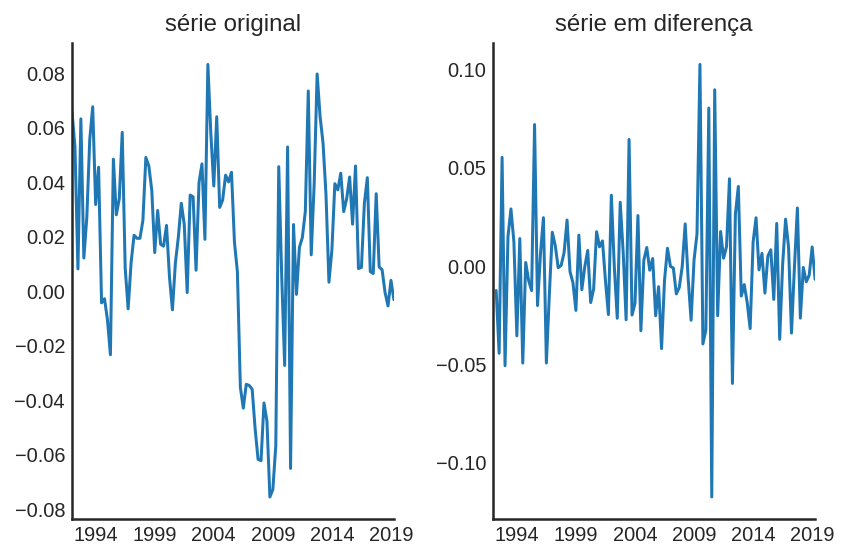

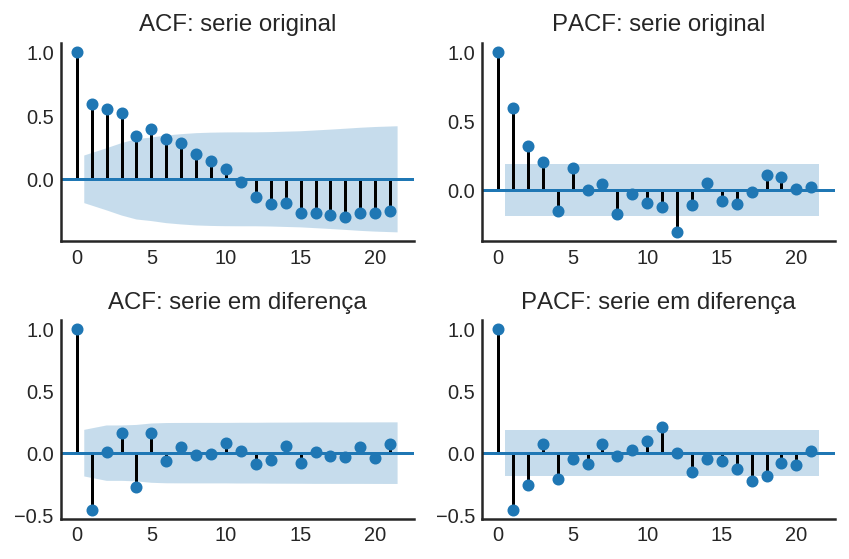


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.439
P-value                         0.139
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.739
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.333
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

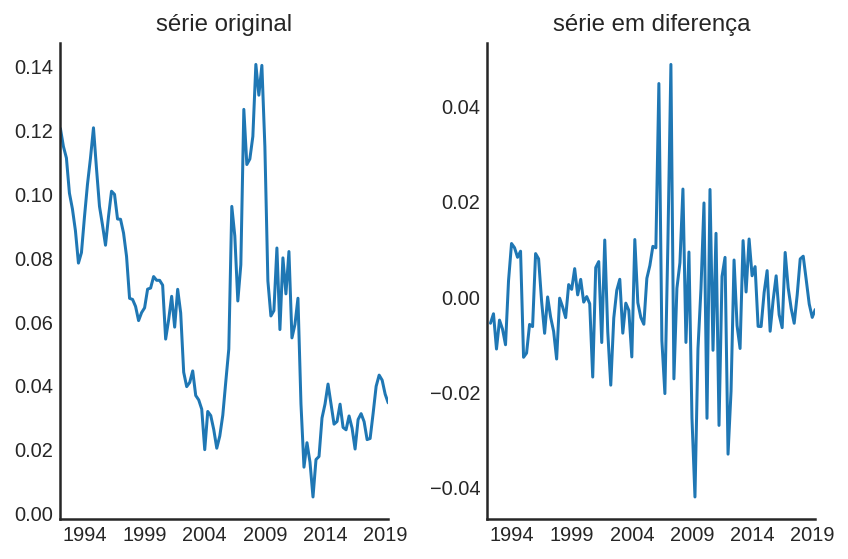

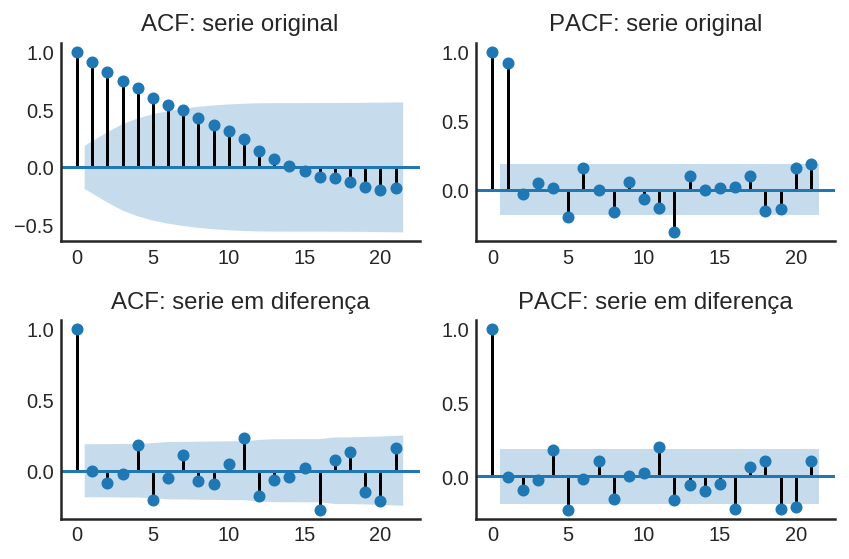


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.203
P-value                         0.237
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -6.340
P-value                         0.000
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.330
P-value 

In [11]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

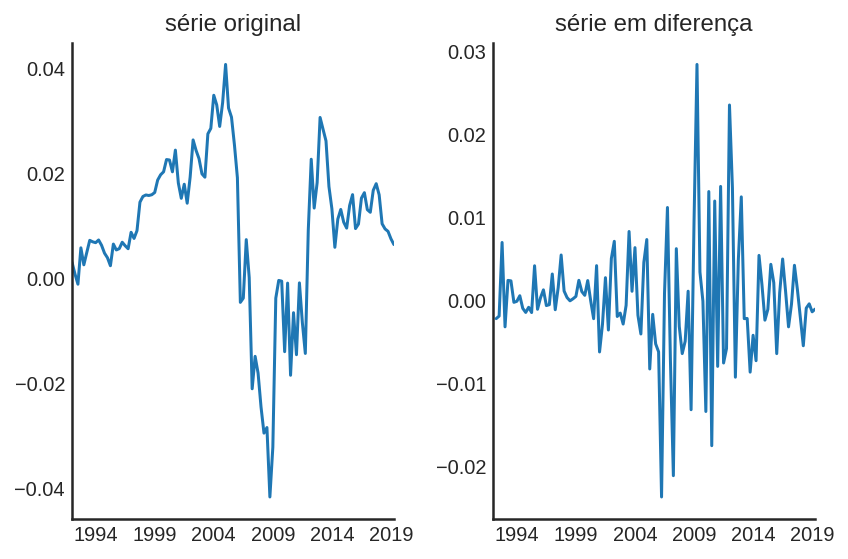

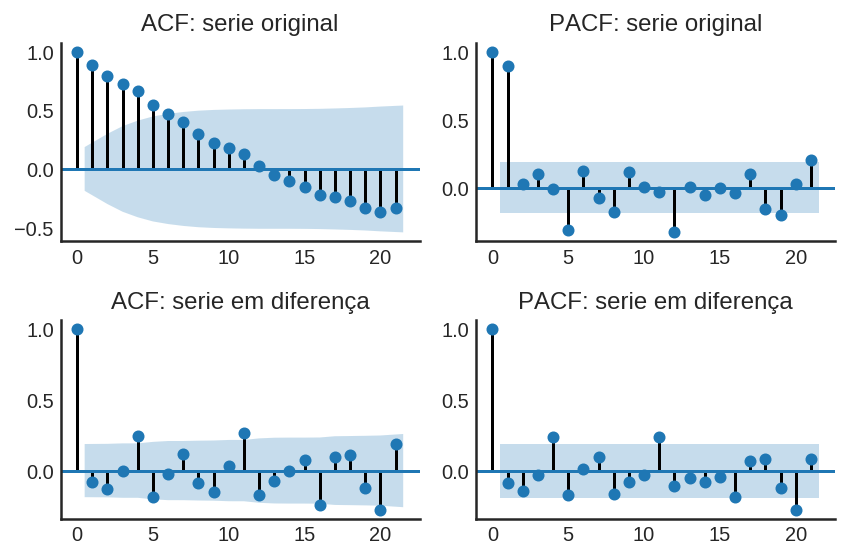


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.871
P-value                         0.043
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -6.122
P-value                         0.001
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.671
P-value 

In [12]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

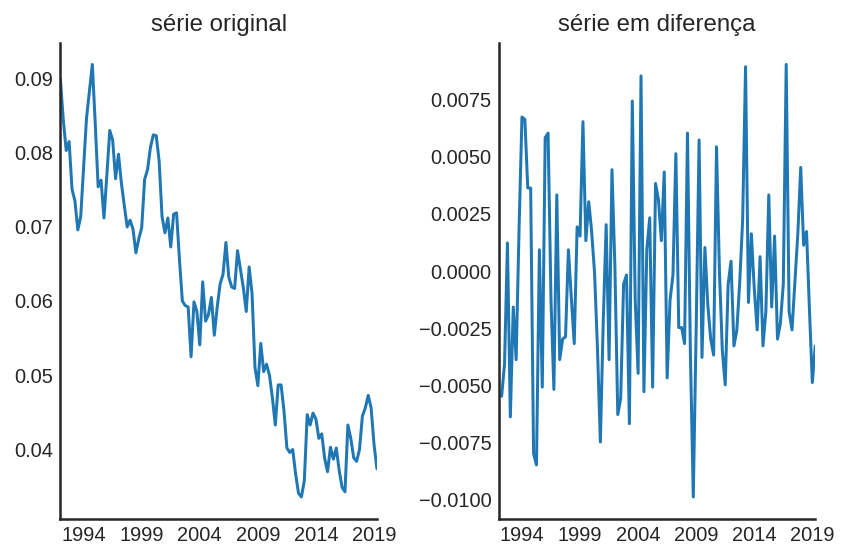

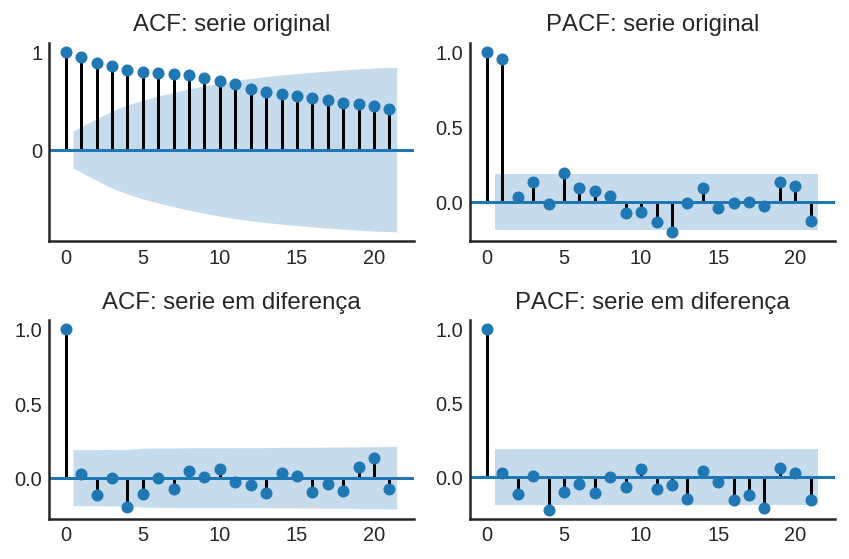


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Taxa Própria']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.83      -14.72   3.643e-07      -14.78
1       -16.33     -16.11*   8.126e-08      -16.24
2       -16.30      -15.97   8.361e-08      -16.17
3       -16.42      -15.99   7.392e-08      -16.25
4       -16.46      -15.92   7.097e-08      -16.25
5      -16.56*      -15.91  6.450e-08*     -16.30*
6       -16.49      -15.74   6.898e-08      -16.19
7       -16.45      -15.59   7.200e-08      -16.11
8       -16.39      -15.42   7.687e-08      -16.00
9       -16.39      -15.31   7.722e-08      -15.95
10      -16.32      -15.14   8.274e-08      -15.85
11      -16.31      -15.02   8.419e-08      -15.79
12      -16.53      -15.13   6.810e-08      -15.97
13      -16.47      -14.96   7.303e-08      -15.86
14      -16.45      -14.84   7.510e-08      -15.80
15      -16.40      -14.68   7.955e-08      -15.71
-----------------

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.209932
p-value: 0.675199
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 6 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -9.988712
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          13.75          12.32
  1   2          2.434          4.130
-------------------------------------
Para lag = 6 e significância = 5.0%, Rank = 1

Teste COM constante

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          11.96          

## $g_Z$, Inflação e taxa de juros

In [15]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.040755
p-value: 0.000118
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.097520
p-value: 0.000518
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -9.710937
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -10.817112
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statis

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -10.817112
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          30.81          24.28
  1   3          15.99          12.32
  2   3          7.402          4.130
-------------------------------------
Para lag = 5 e significância = 5.0%, Rank = 3

Teste COM constante

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          24.15          29.80
-------------------------------------
Para lag = 5 e significância = 5.0%, Rank = 0

Teste COM constante E tendência

Johansen cointegration test using trace test statistic with 5% significance 

## $g_Z$ e Inflação

In [16]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.107785
p-value: 0.000011
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.064438
p-value: 0.000125
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.034058
p-value: 0.000752
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.186070
p-value: 0.001684
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statist

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.842193
p-value: 0.152628
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 5 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.794435
p-value: 0.361320
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 5 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.820552
p-value: 0.560025
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          19.03          12.32
  1   2          5.190          4.130
-------------------------------------
Para lag 

# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

#det = 'cili'
#det = 'coli'
#det = 'colo'
det = 'cilo'
#det = 'ci'
#det = 'nc'
#det= 'co'

order_vec = select_order(
    df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    #seasons=4,
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-16.26,-15.99*,8.658e-08,-16.15
1,-16.24,-15.86,8.894e-08,-16.08
2,-16.36,-15.87,7.889e-08,-16.16
3,-16.40,-15.80,7.583e-08,-16.16
4,-16.49*,-15.79,6.893e-08*,-16.21*
5,-16.43,-15.62,7.373e-08,-16.10
6,-16.38,-15.46,7.721e-08,-16.01
7,-16.32,-15.29,8.239e-08,-15.91
8,-16.32,-15.19,8.279e-08,-15.86
9,-16.26,-15.01,8.875e-08,-15.76


## Estimação

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
lin_trend       -1.632e-05    4.4e-05     -0.371      0.710      -0.000    6.98e-05
L1.Taxa Própria     0.0381      0.111      0.342      0.732      -0.180       0.256
L1.gZ               0.0738      0.083      0.887      0.375      -0.089       0.237
L2.Taxa Própria    -0.0032      0.110     -0.029      0.977      -0.218       0.212
L2.gZ               0.1115      0.082      1.366      0.172      -0.048       0.272
L3.Taxa Própria     0.0757      0.118      0.642      0.521      -0.156       0.307
L3.gZ               0.1080      0.069      1.563      0.118      -0.027       0.243
L4.Taxa Própria     0.2649      0.119      2.230      0.026       0.032       0.498
L4.gZ               0.0583      0.054      1.089      0.276      -0.

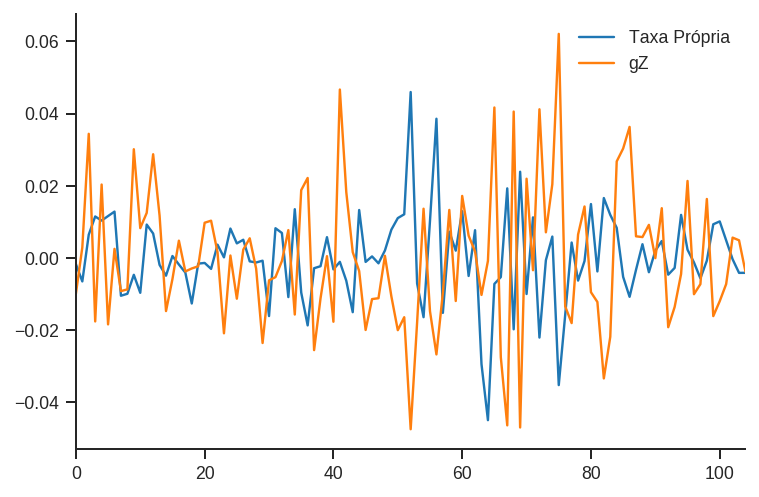

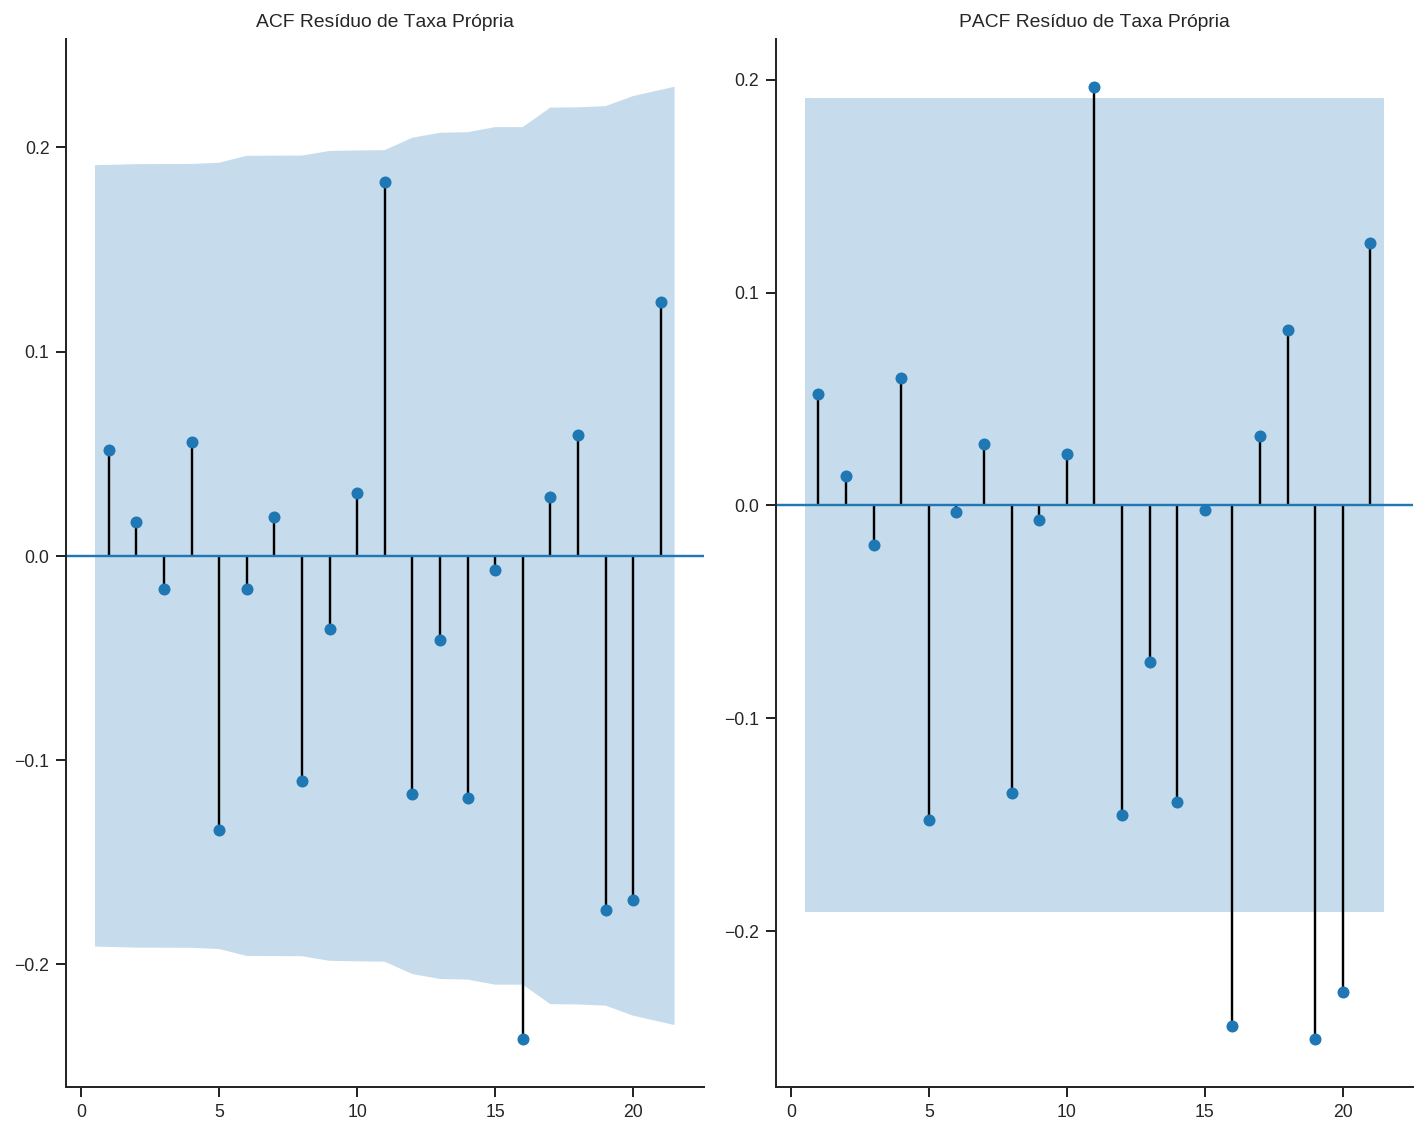

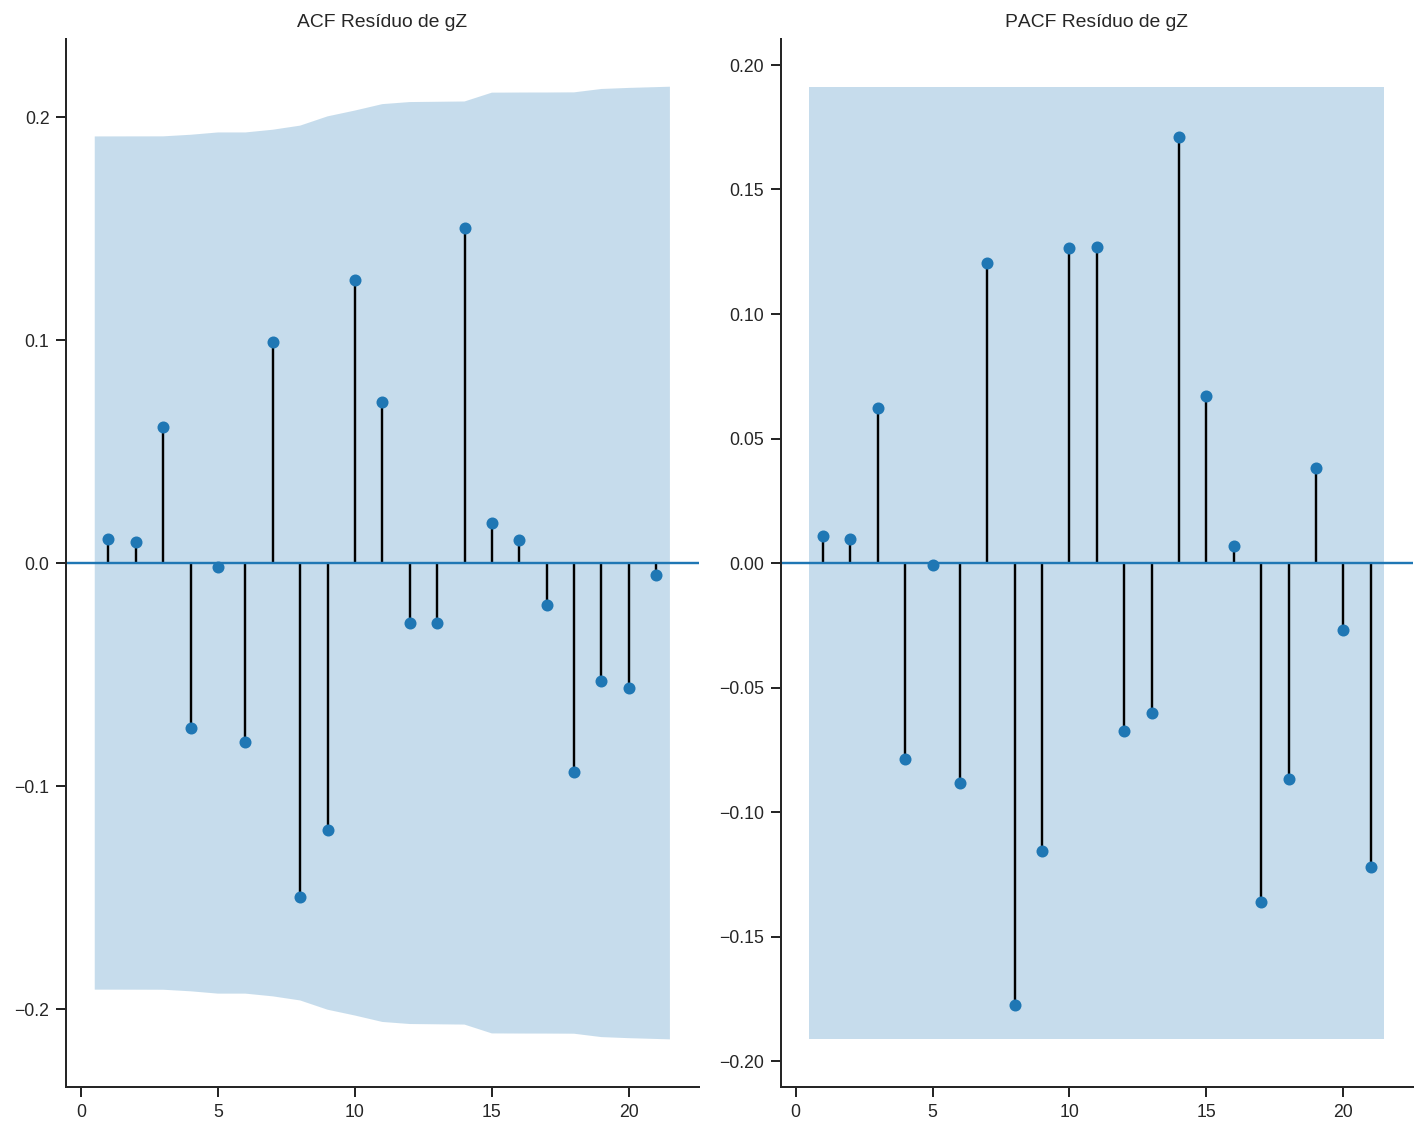

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         49.58          58.12   0.197 42
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         54.51          58.12   0.093 42
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.9125965992793943
Reject H0 on lag  1 ?  False 

p-value = 0.9891274

In [43]:
model = VECM(
    endog = df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    #k_ar_diff=0,
    #k_ar_diff=1,
    #k_ar_diff=2,
    #k_ar_diff=3,
    k_ar_diff=4,
    #k_ar_diff=5,
    #k_ar_diff=6,
    #k_ar_diff=7,
    #k_ar_diff=8,
    deterministic=det, 
    #seasons=4,
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

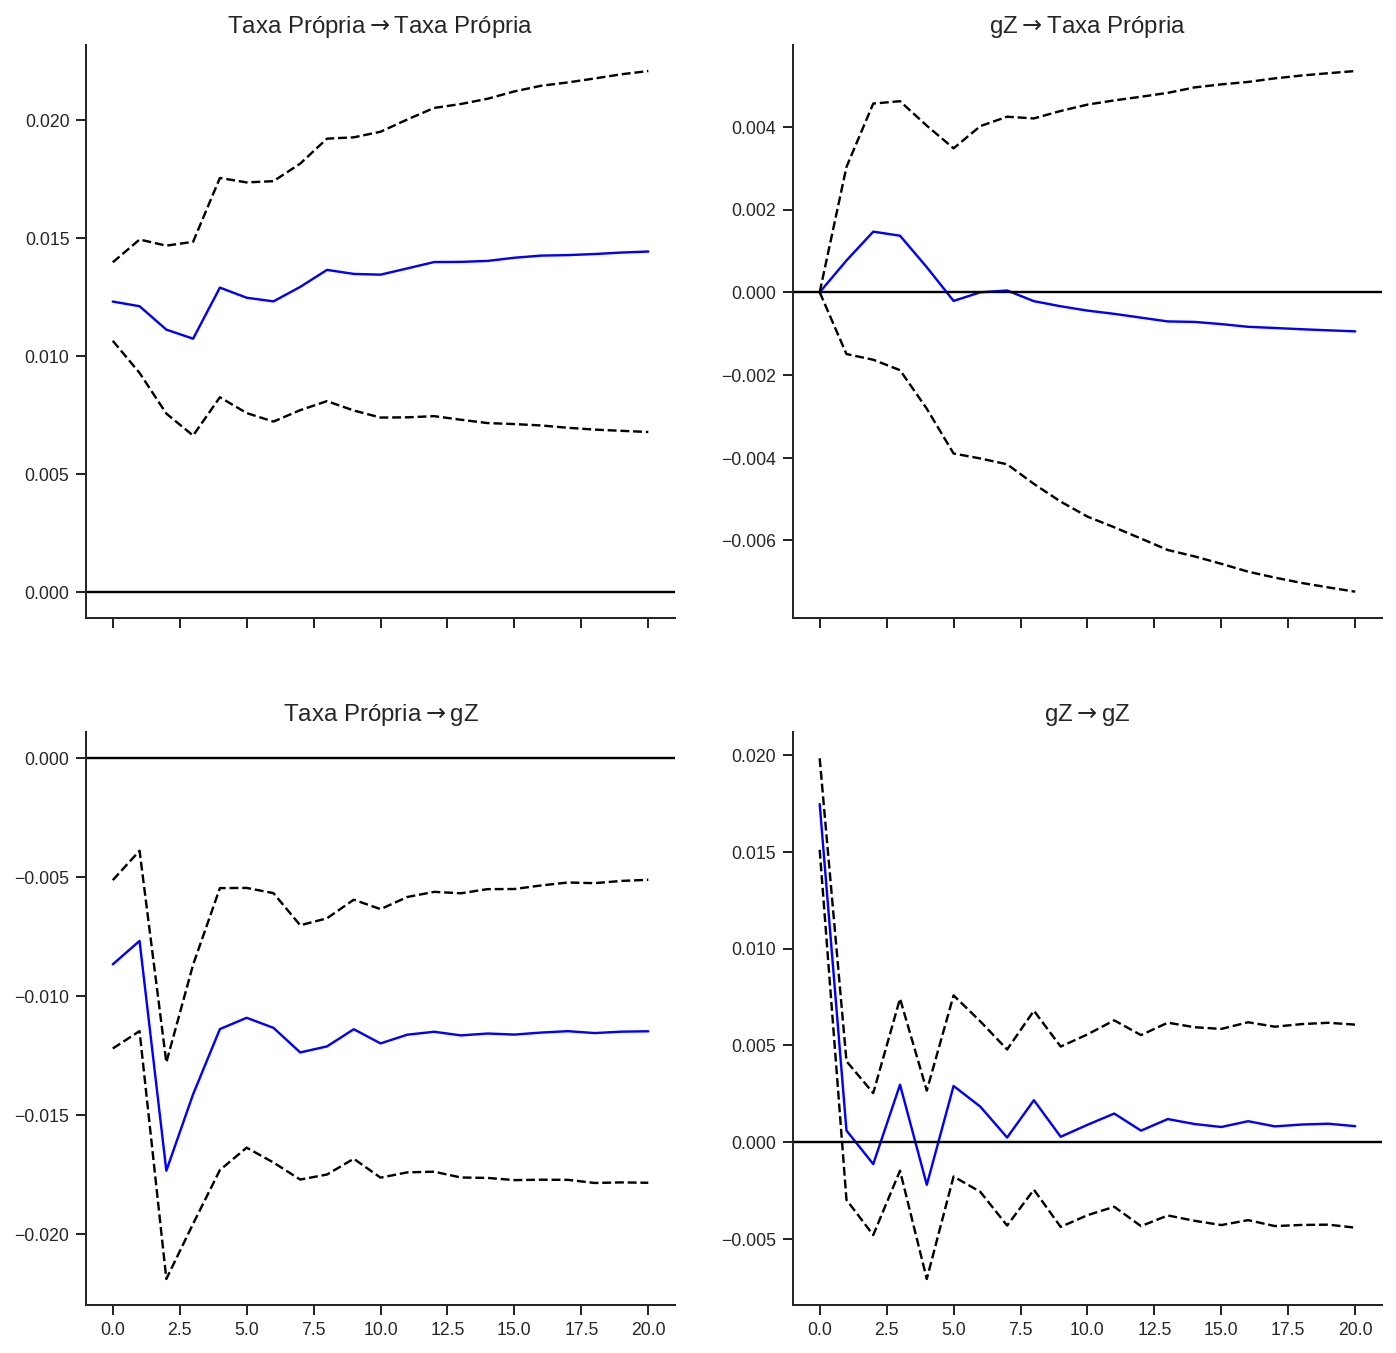

In [19]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

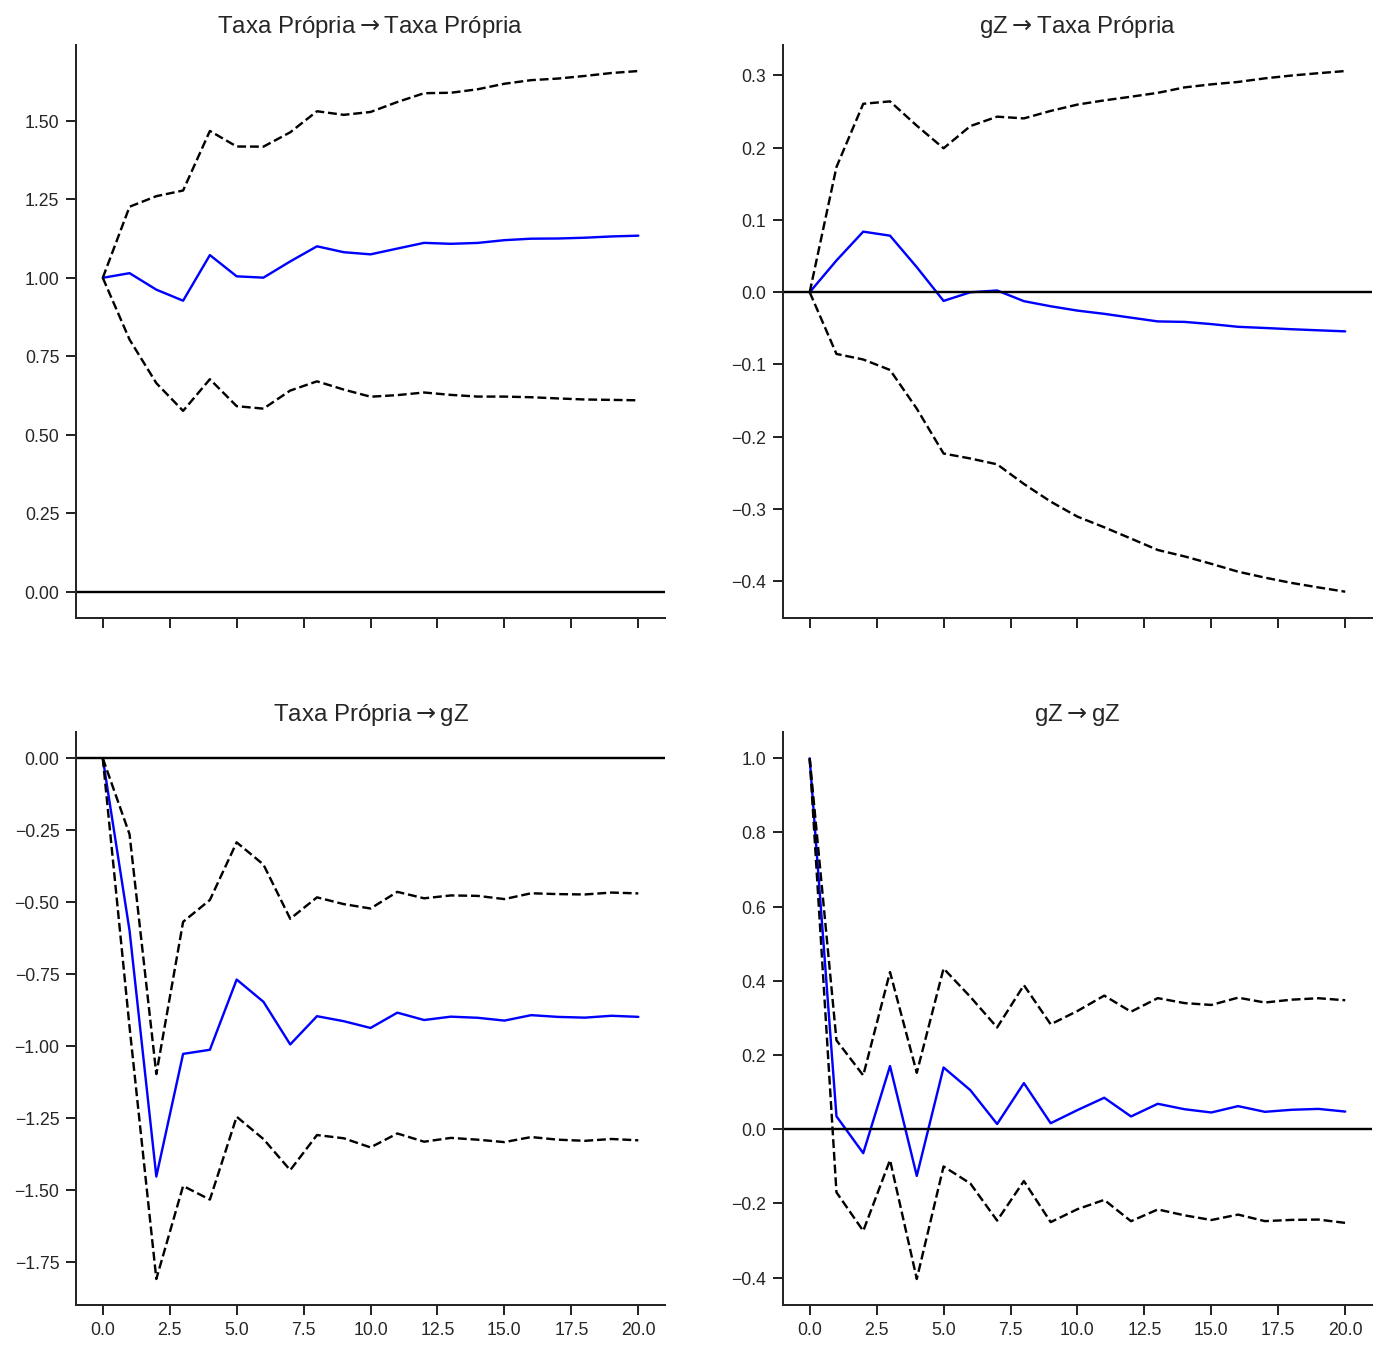

In [20]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Teste de causalidade de granger

In [21]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Taxa Própria does not Granger-cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         12.28          2.264   0.000 (5, 180)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Taxa Própria does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.44          3.841   0.000  1
----------------------------------------


## Inspeção gráfica dos resíduos

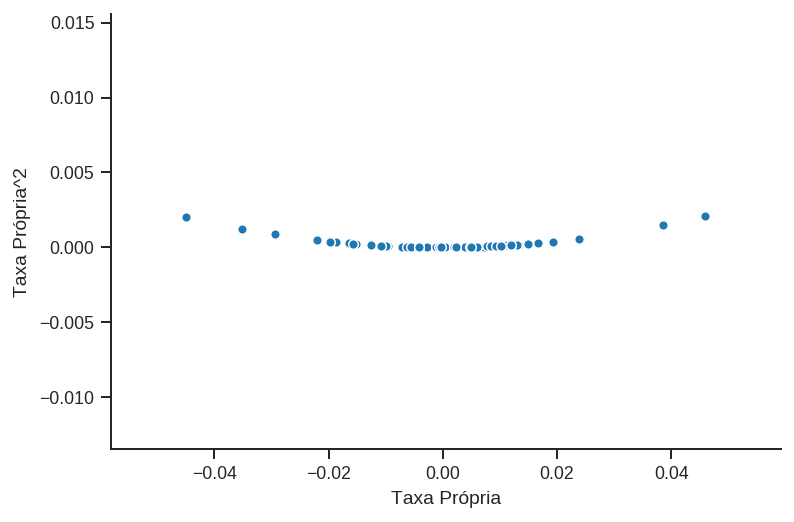

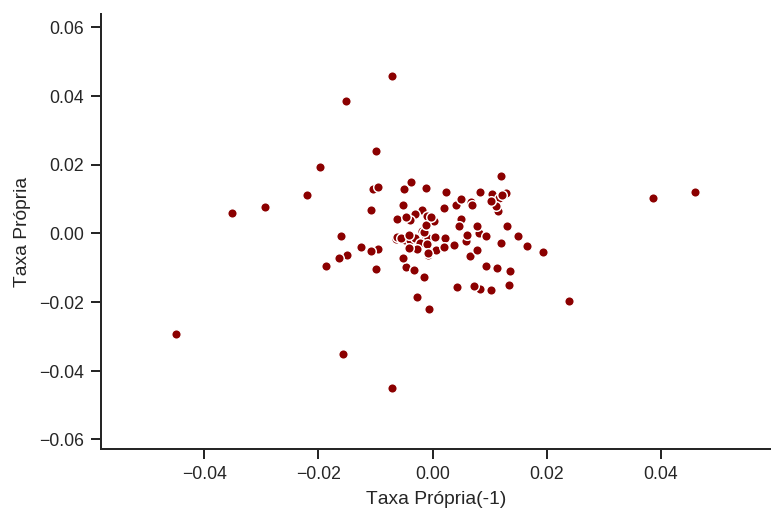

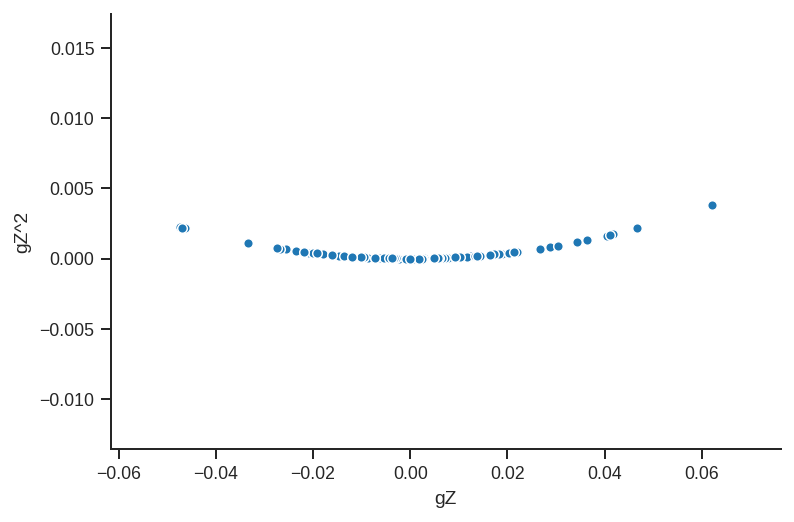

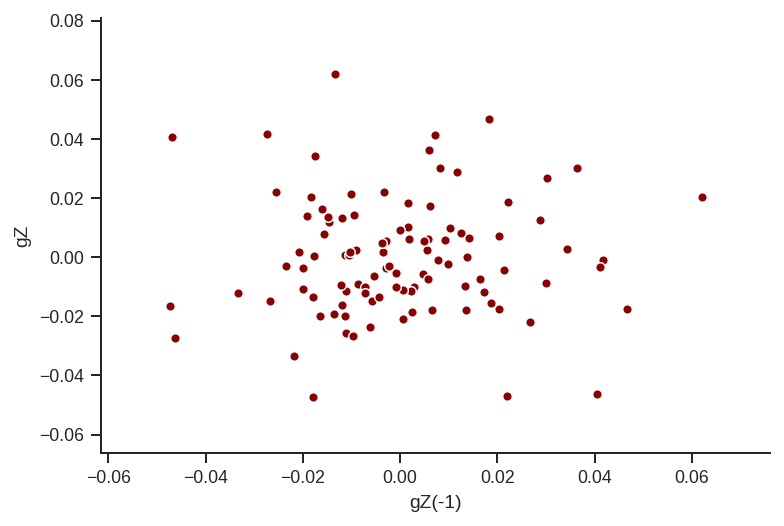

In [22]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

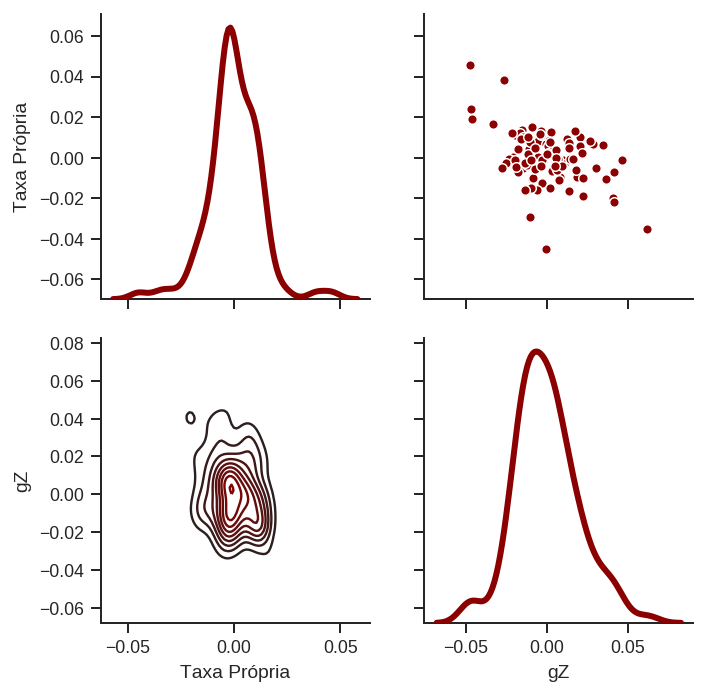

In [23]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

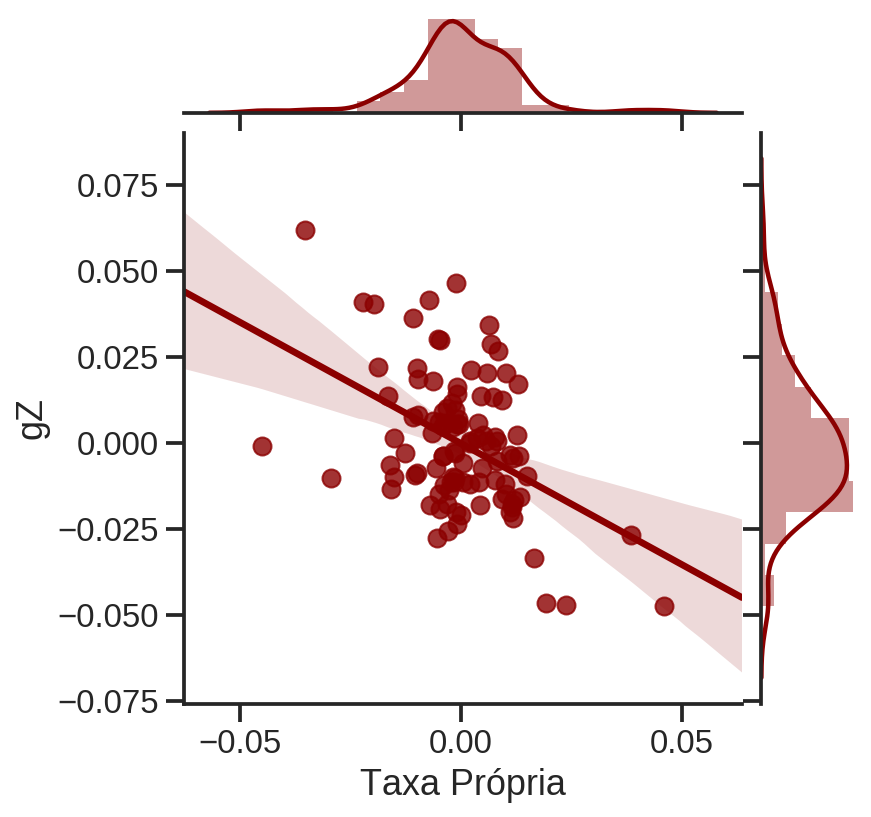

In [24]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

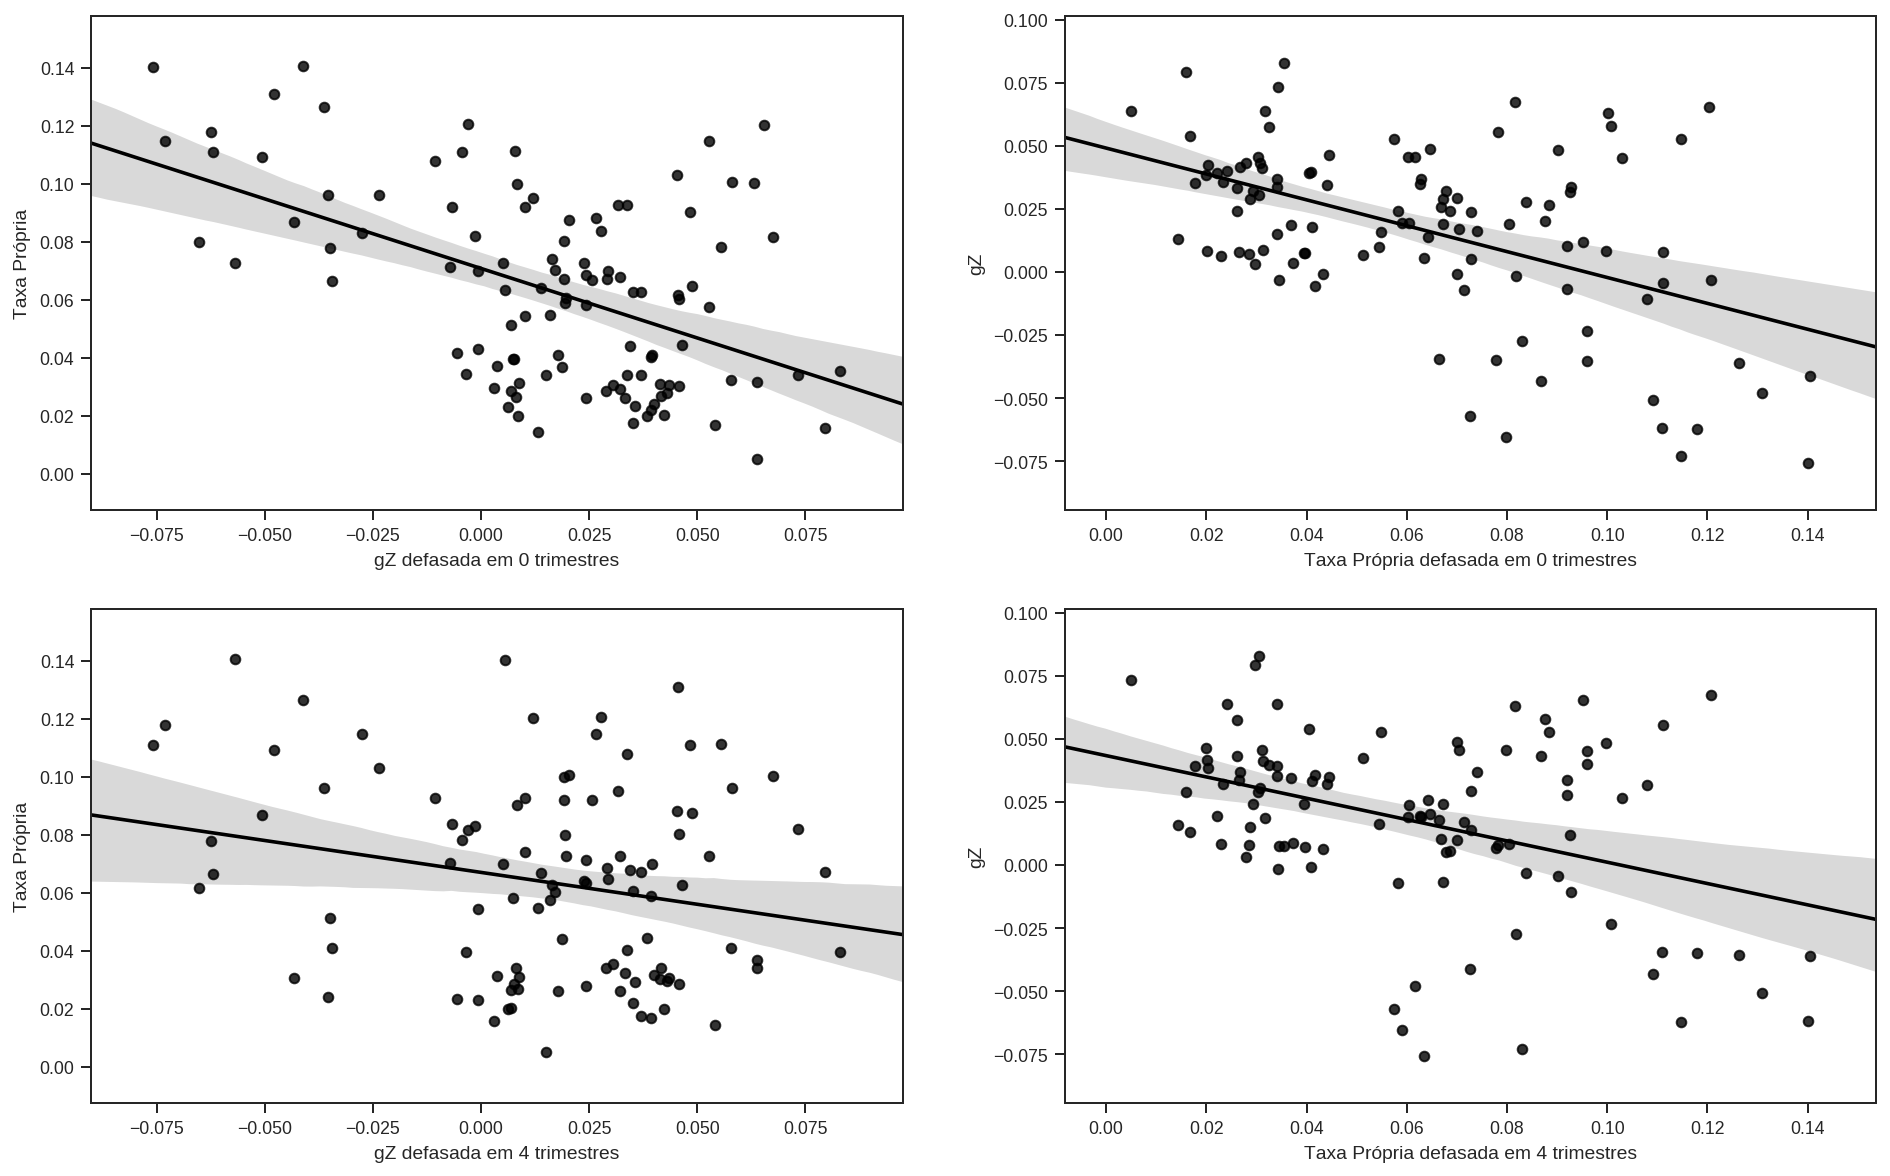

In [25]:
fig = plot_lags(results=results, trimestres=[0,4])
fig.savefig("./figs/VEC_Defasagens.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## FEVD

In [26]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
#df <- df[,c(4:7)]
names(df) <- c("Infla", "gZ", "TaxaP", "Juros")
df <- na.omit(df[,c("Infla", "gZ", "TaxaP", "Juros")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("TaxaP","gZ")], lag = 4, r = 1, estim = "ML", LRinclude="both", include="none")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [27]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

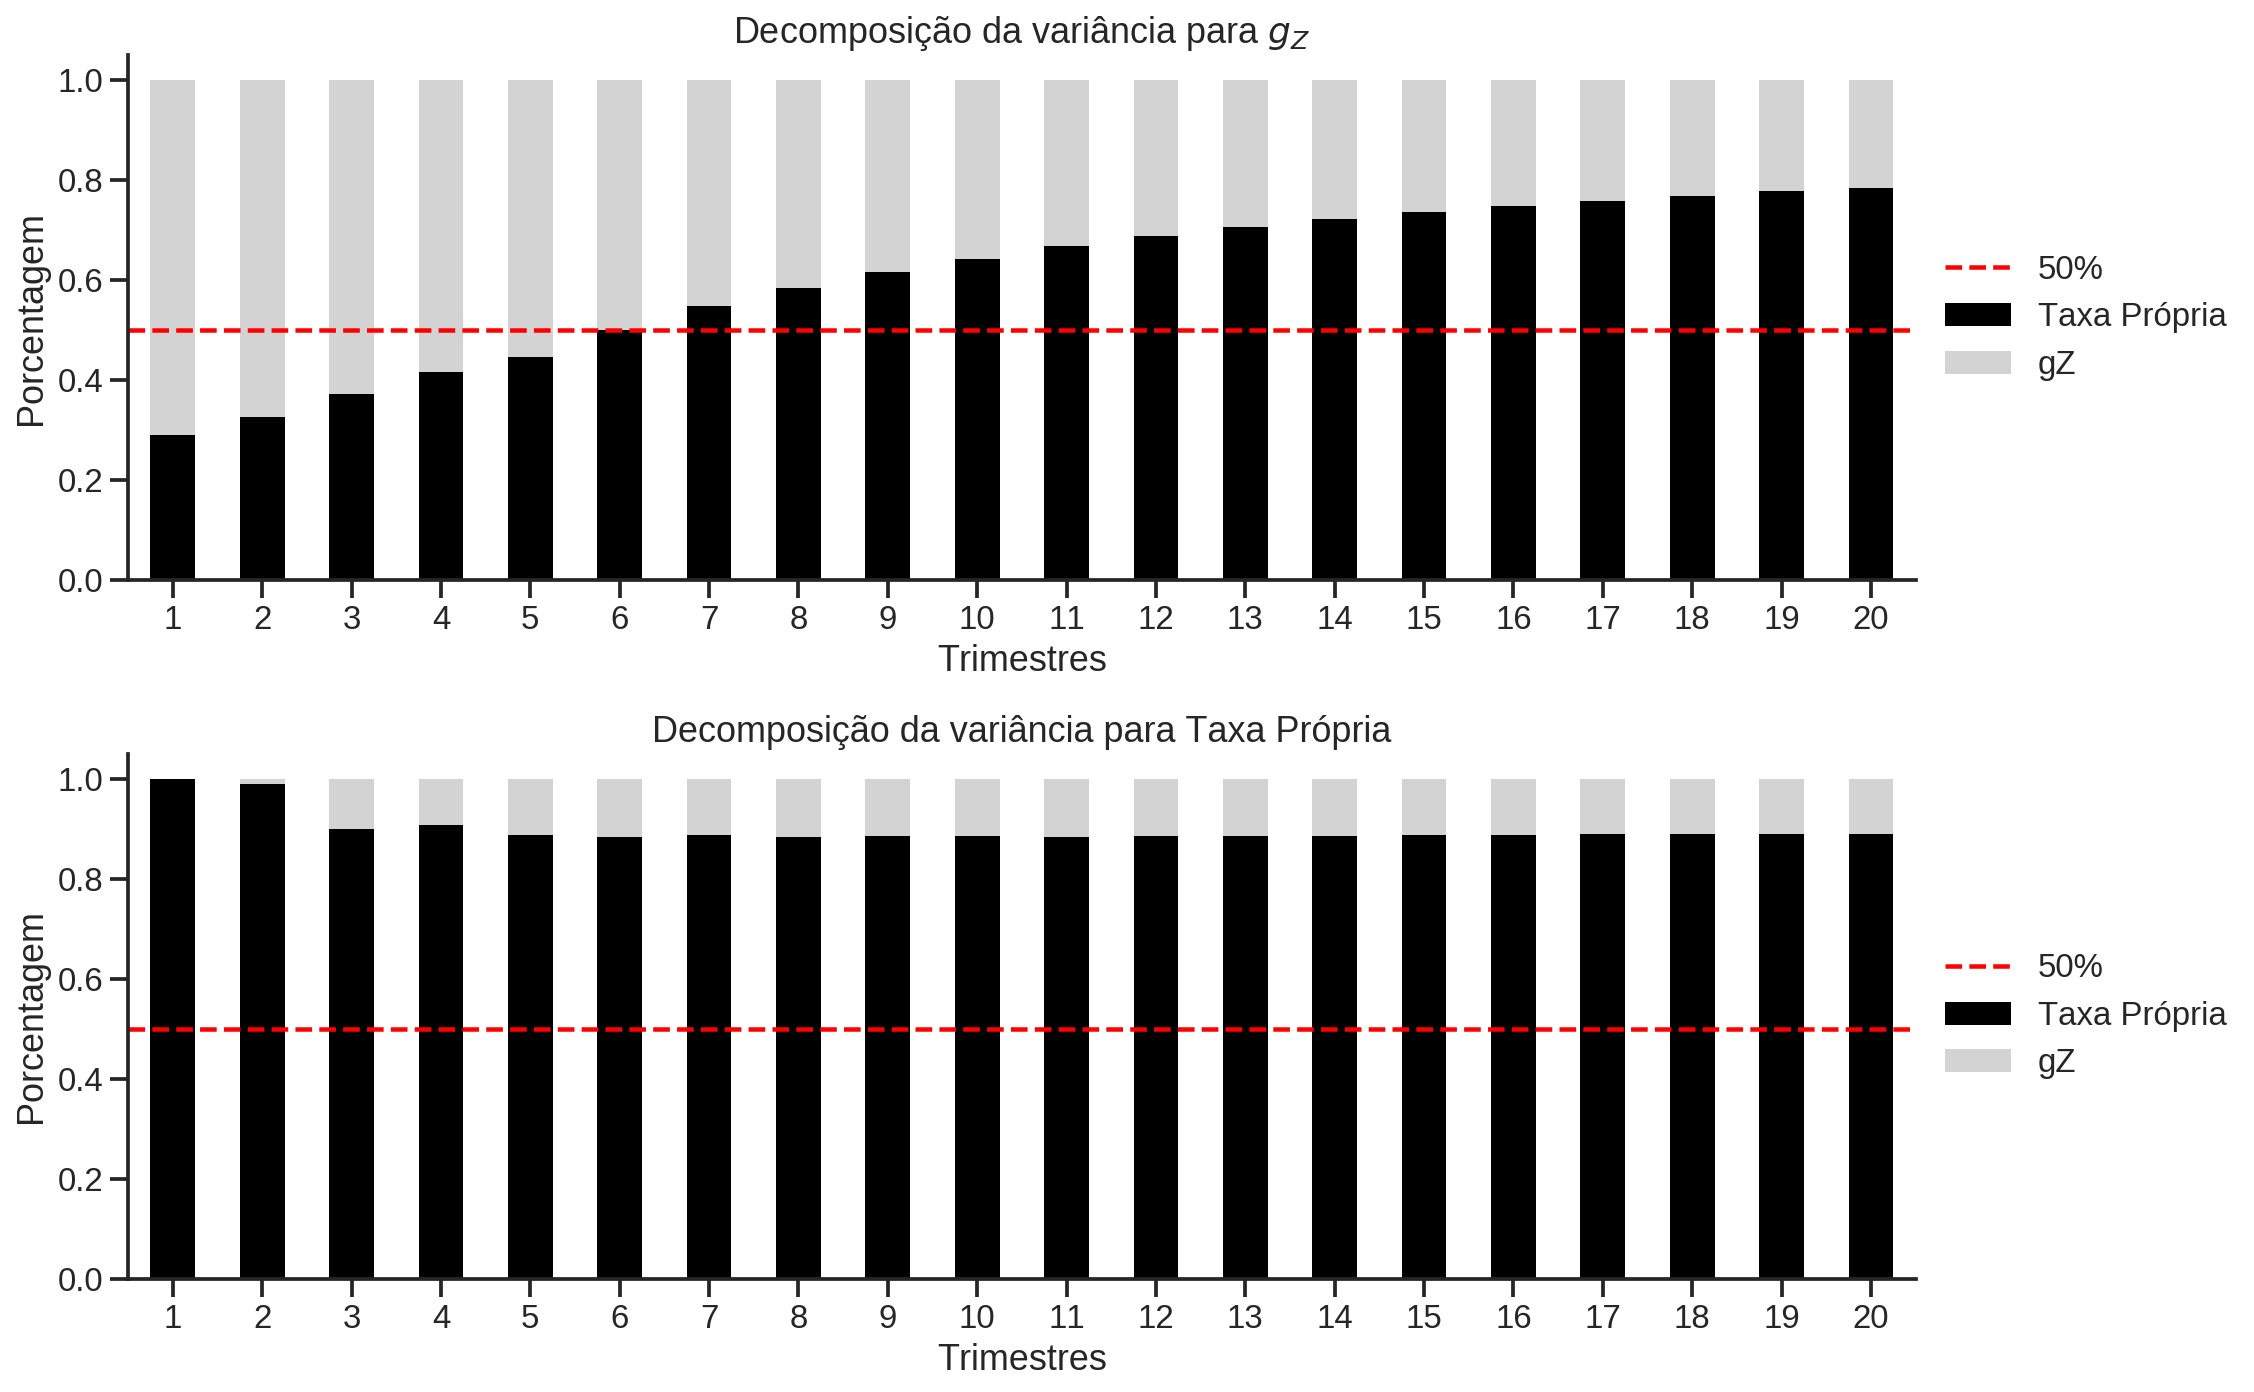

In [28]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Taxa Própria", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Estacionariedade dos resíduos

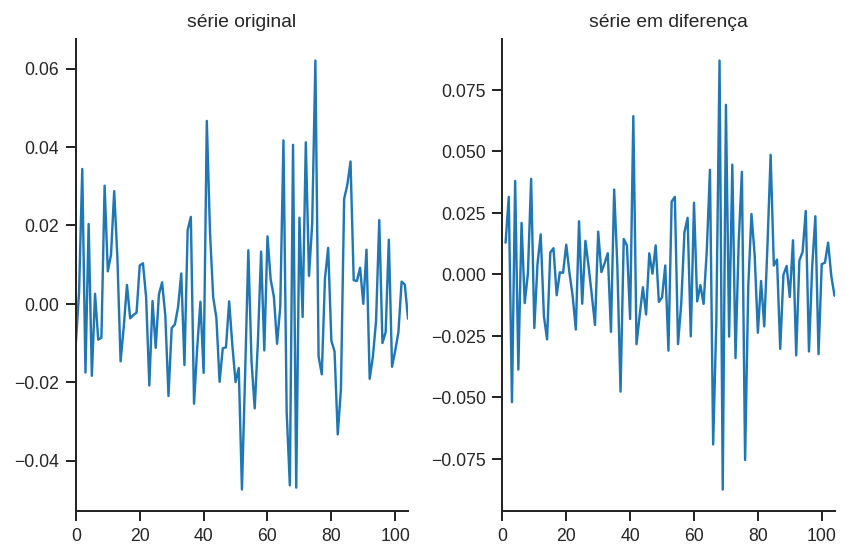

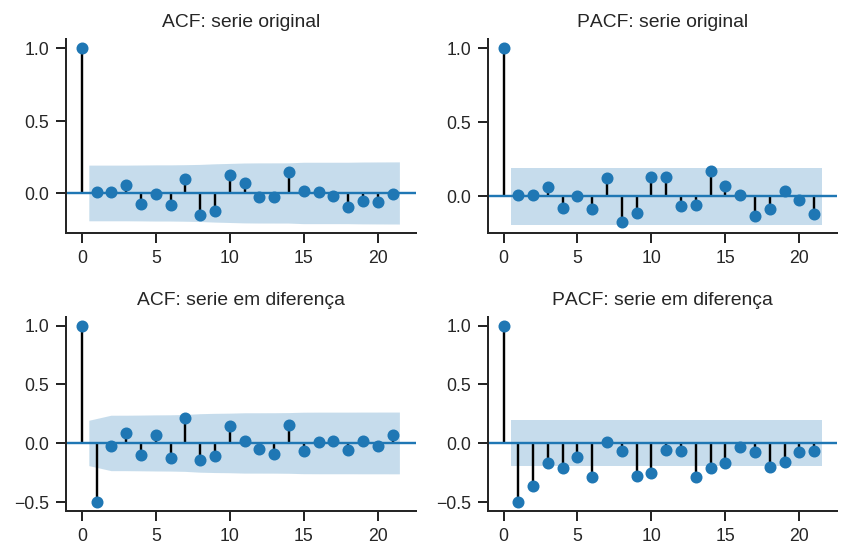


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                -10.602
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -6.306
P-value                         0.001
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                -10.004
P-value 

In [44]:
testes_raiz(residuals['gZ'])

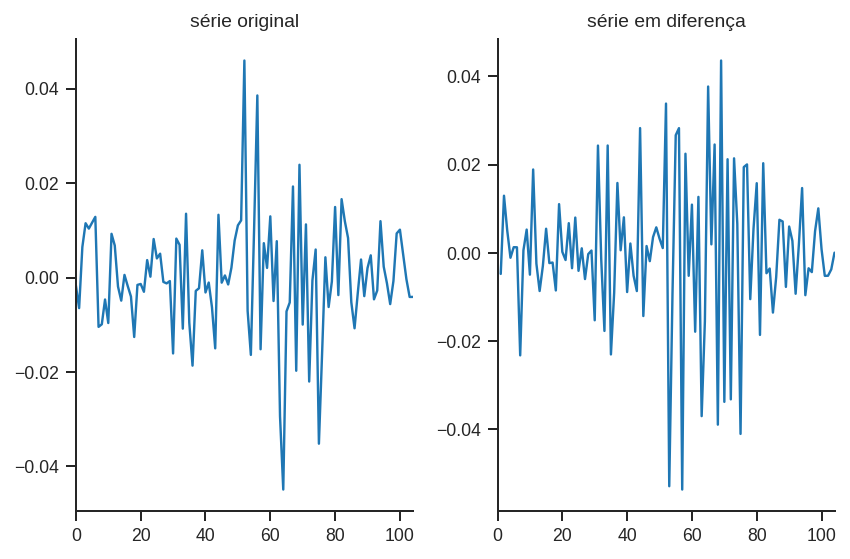

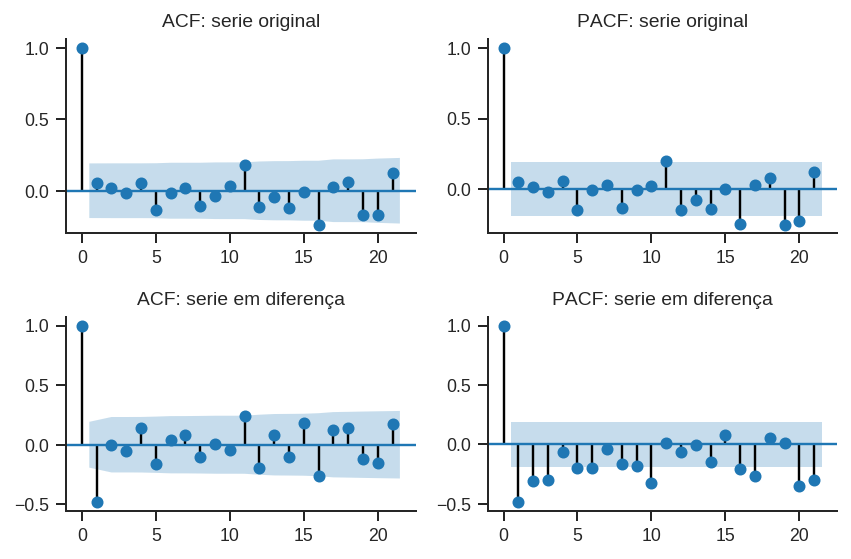


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                -10.041
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -6.783
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -9.585
P-value 

In [45]:
testes_raiz(residuals['Taxa Própria'])

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [29]:
model = VAR(
    df[["d_Taxa Própria", 'd_gZ']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -15.74      -15.63   1.462e-07      -15.69
1       -15.90      -15.69   1.243e-07      -15.81
2       -16.24     -15.92*   8.869e-08      -16.11
3       -16.20      -15.77   9.223e-08      -16.03
4       -16.33      -15.80  8.070e-08*     -16.12*
5       -16.33      -15.68   8.128e-08      -16.07
6       -16.30      -15.55   8.337e-08      -16.00
7       -16.24      -15.38   8.896e-08      -15.89
8       -16.27      -15.31   8.646e-08      -15.88
9       -16.23      -15.16   9.025e-08      -15.80
10      -16.24      -15.06   9.018e-08      -15.76
11     -16.35*      -15.06   8.133e-08      -15.83
12      -16.32      -14.92   8.410e-08      -15.75
13      -16.30      -14.79   8.646e-08      -15.69
14      -16.22      -14.61   9.409e-08      -15.57
15      -16.16      -14.44   1.016e-07      -15.46
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [30]:
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           sex, 13, dez, 2019
Time:                     10:29:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.9206
Nobs:                     106.000    HQIC:                  -16.1896
Log likelihood:           584.948    FPE:                7.75719e-08
AIC:                     -16.3729    Det(Omega_mle):     6.59053e-08
--------------------------------------------------------------------
Results for equation d_Taxa Própria
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000225         0.001274           -0.177           0.860
L1.d_Taxa Própria         0.026791         0.108015            0.248           0.804
L1.d_gZ                   0.053280 

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

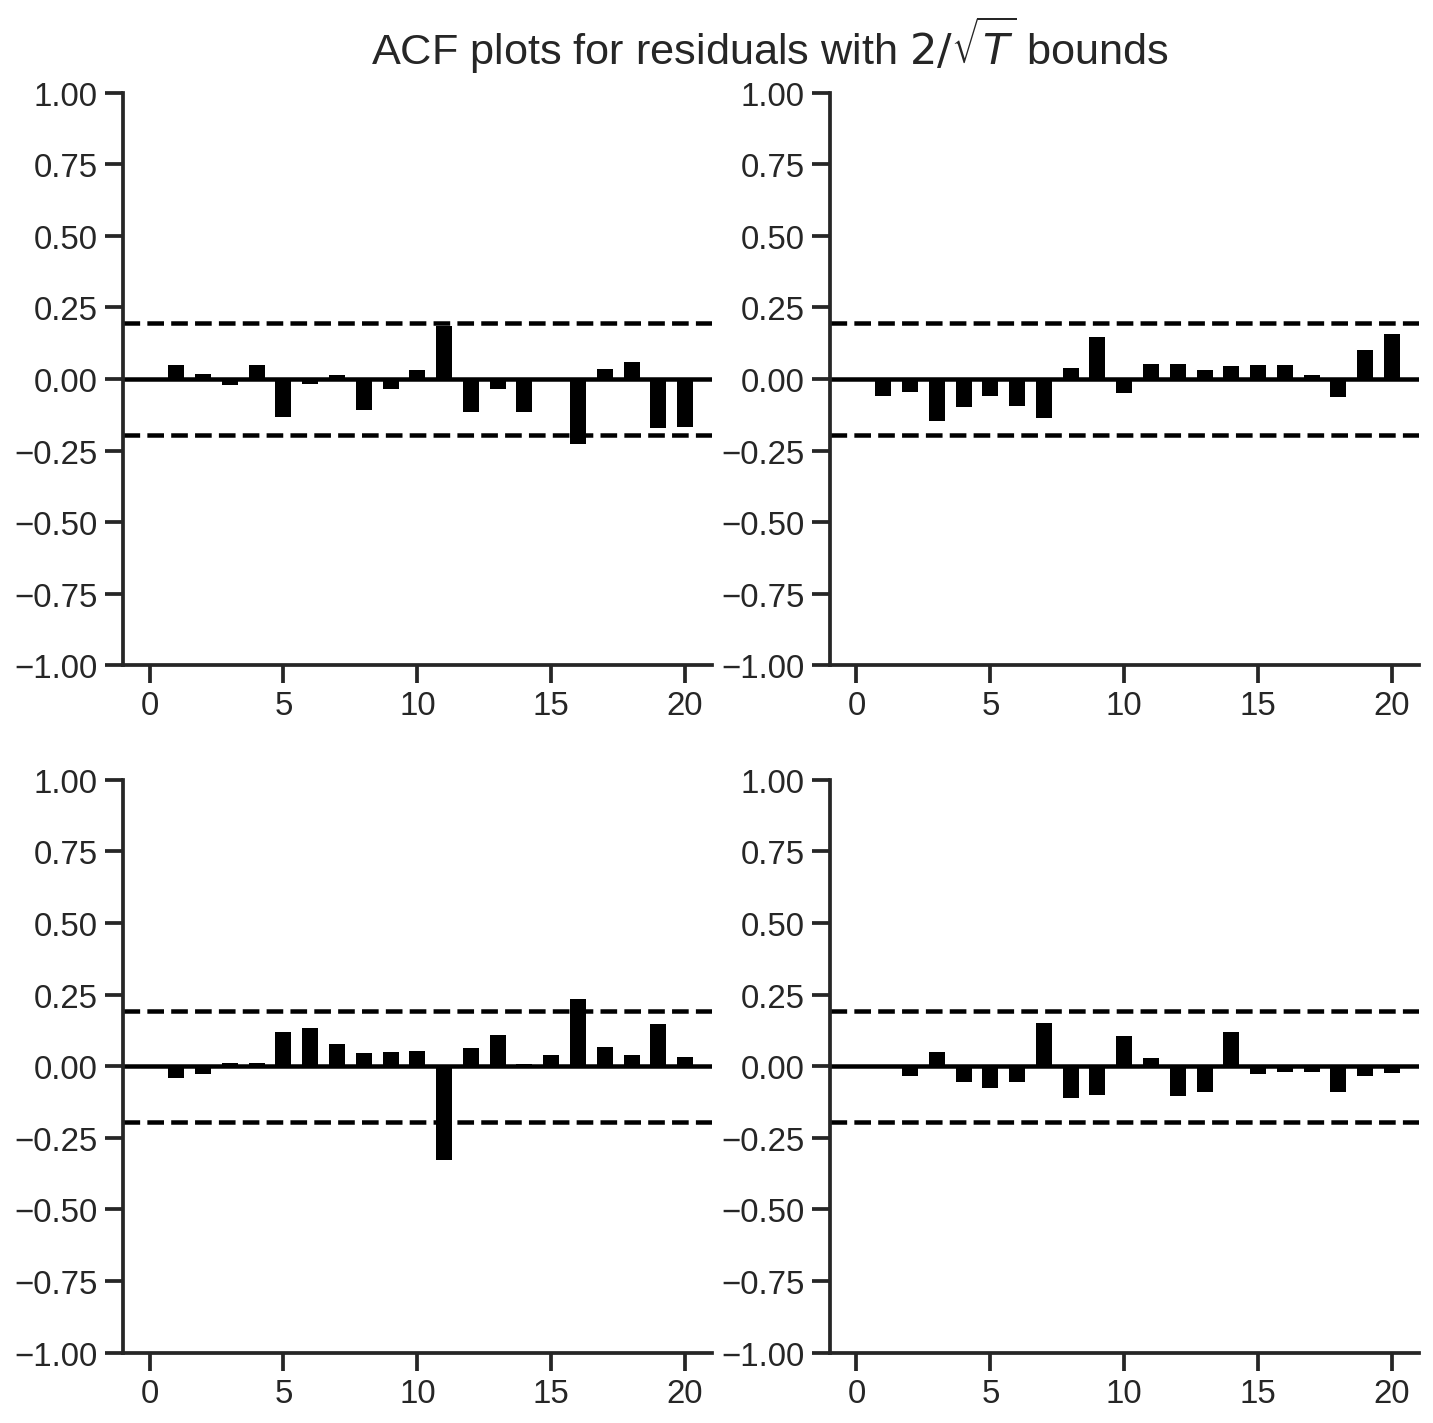

In [31]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [32]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.6028981520089486
0.7019925401767092
0.7019925401767092
0.7432362599067193
0.7432362599067193
0.6605408378835657
0.8122883049550694
0.8122883049550694
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

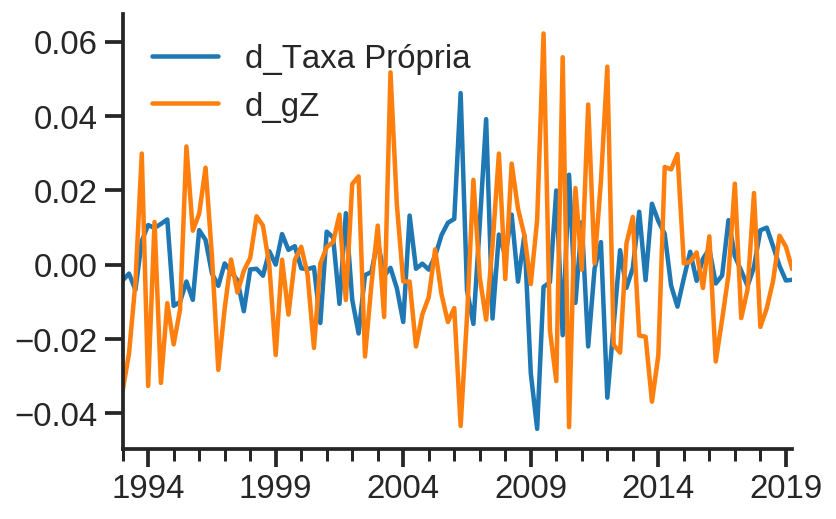

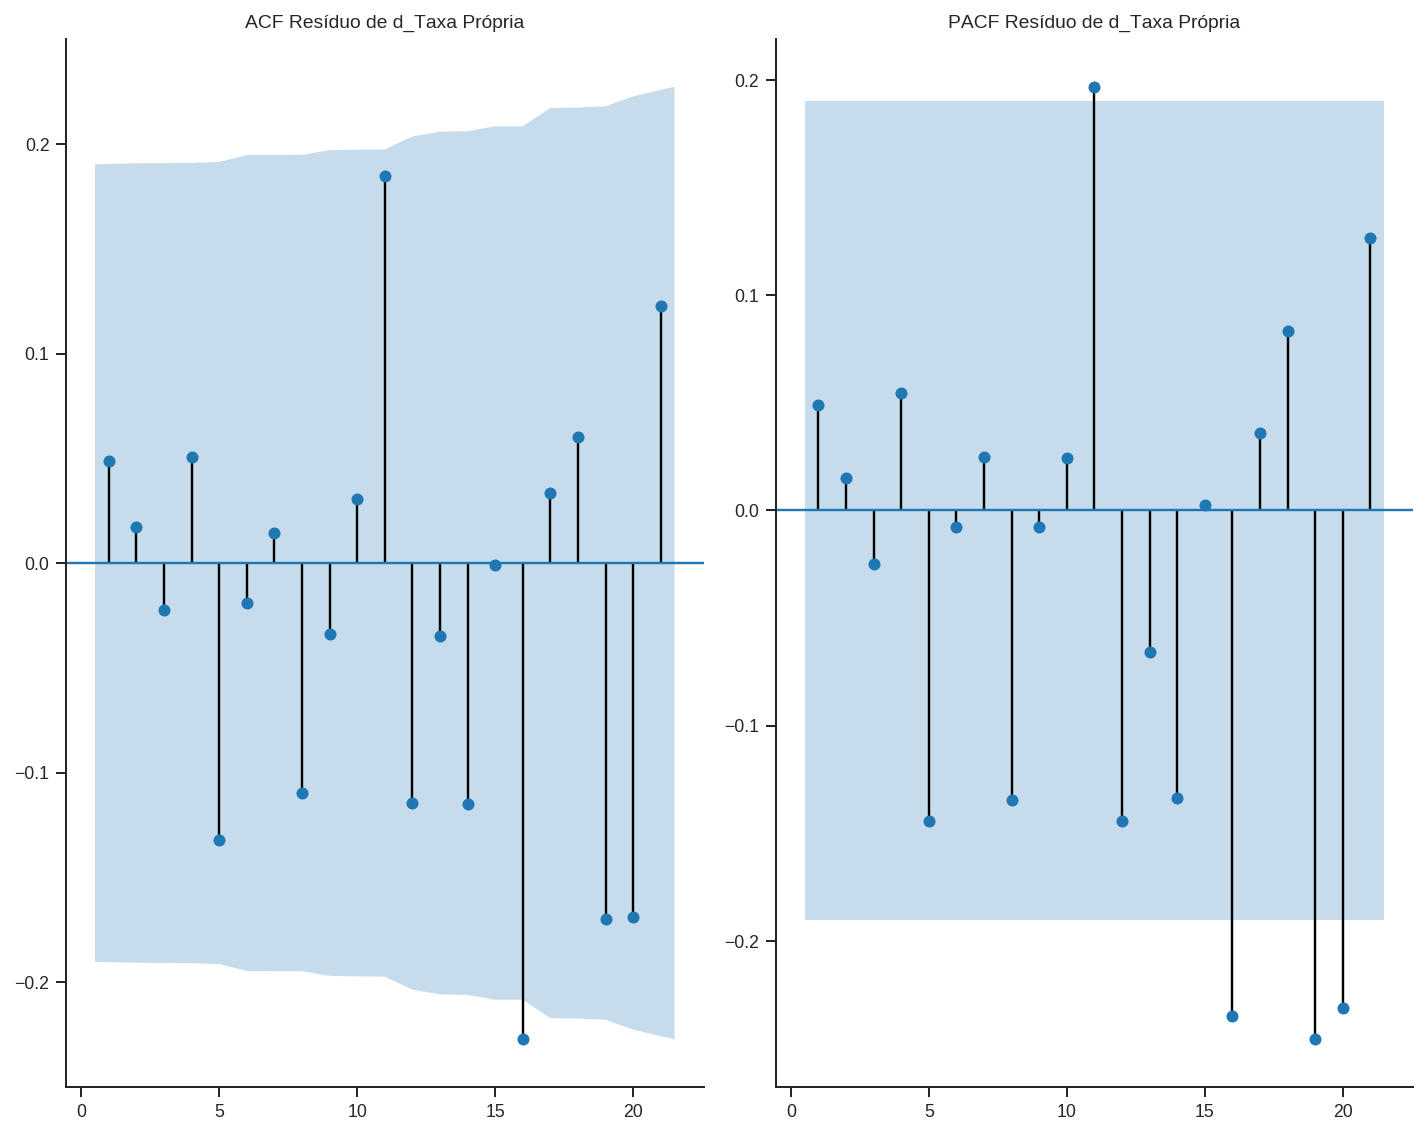

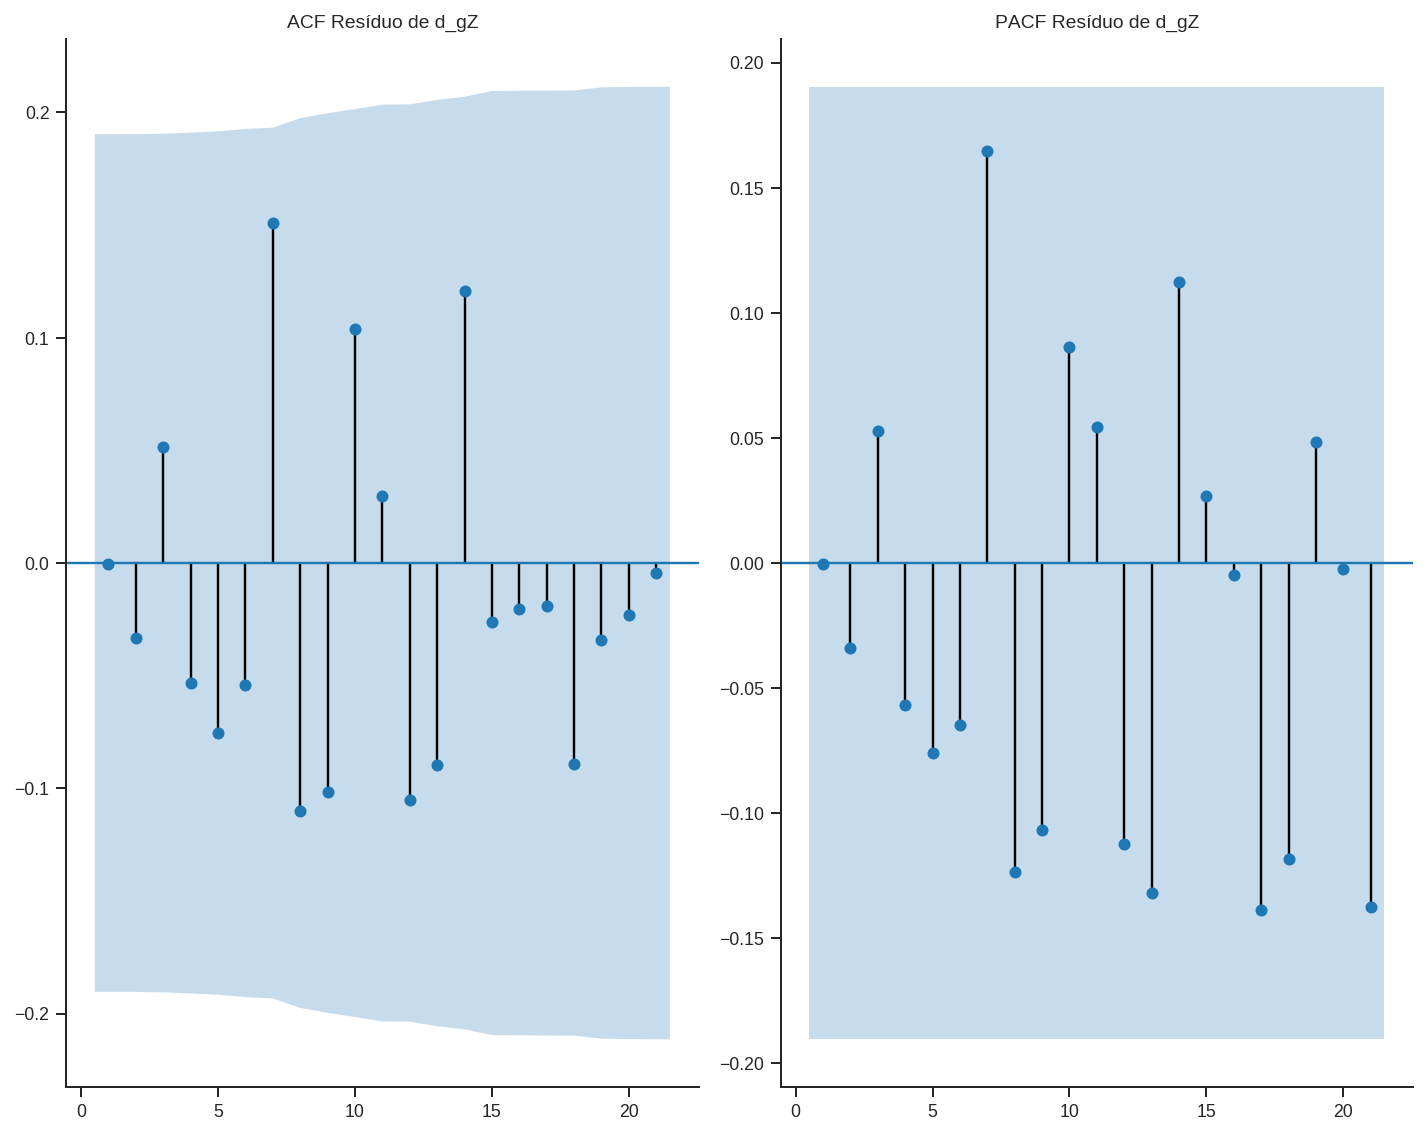

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         50.83          60.48   0.222 44
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         55.42          60.48   0.116 44
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.996228493554174
Reject H0 on lag  1 ?  False 

p-value = 0.940629

In [33]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

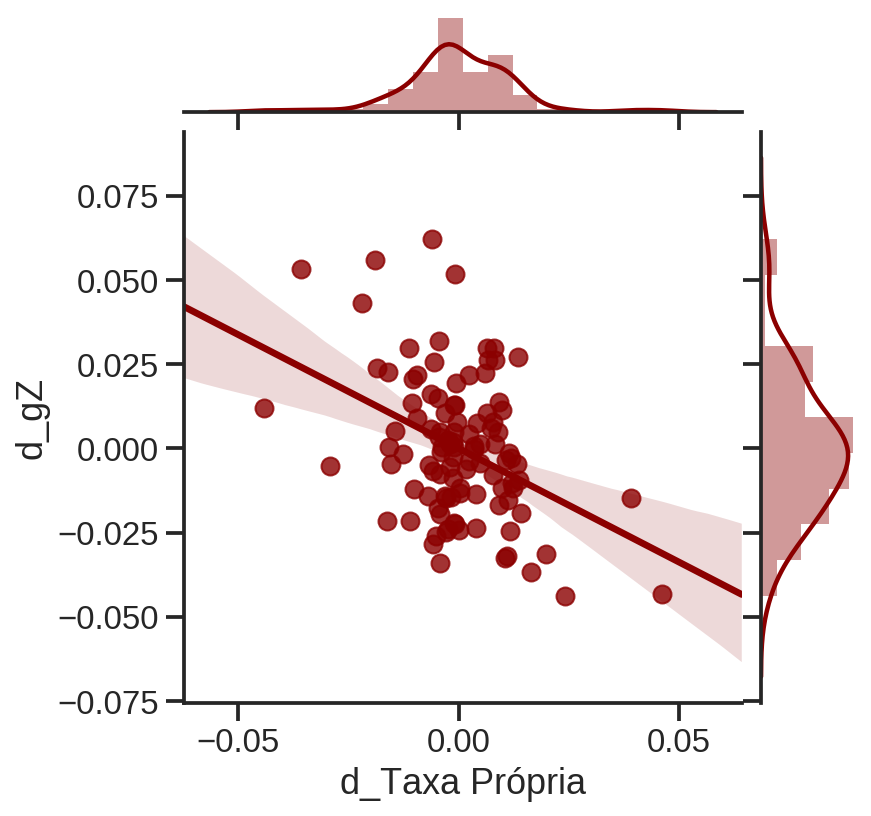

In [34]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

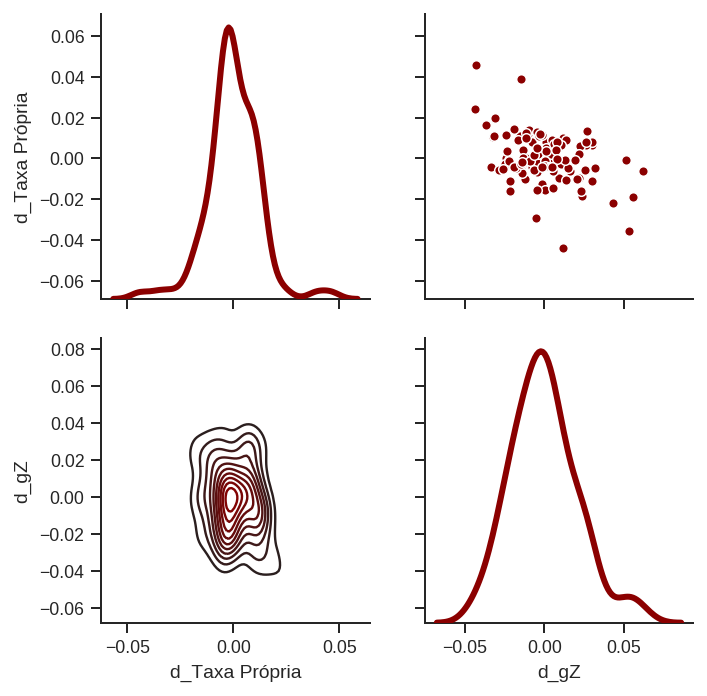

In [35]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

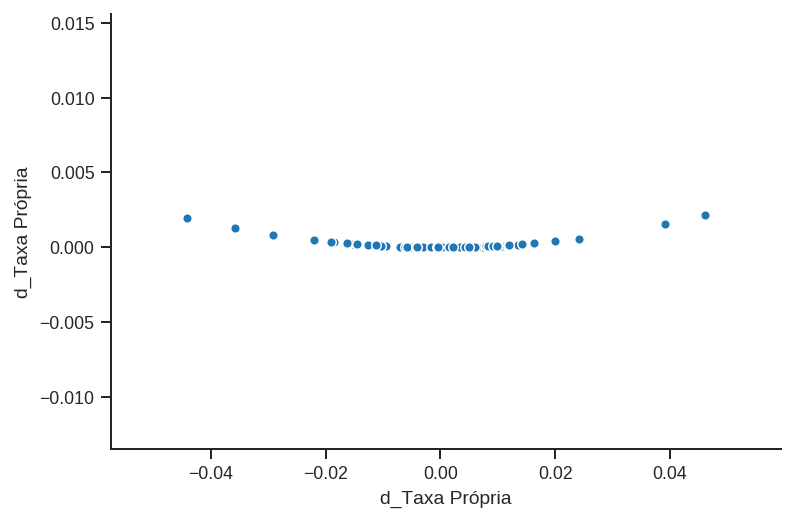

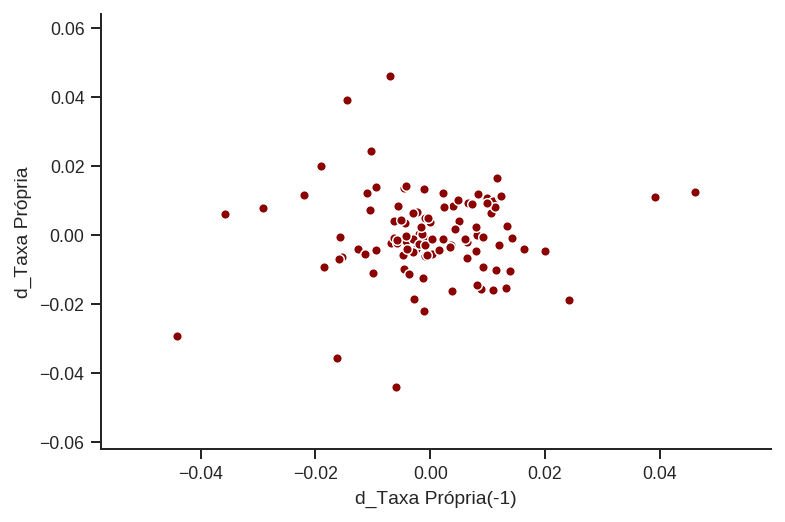

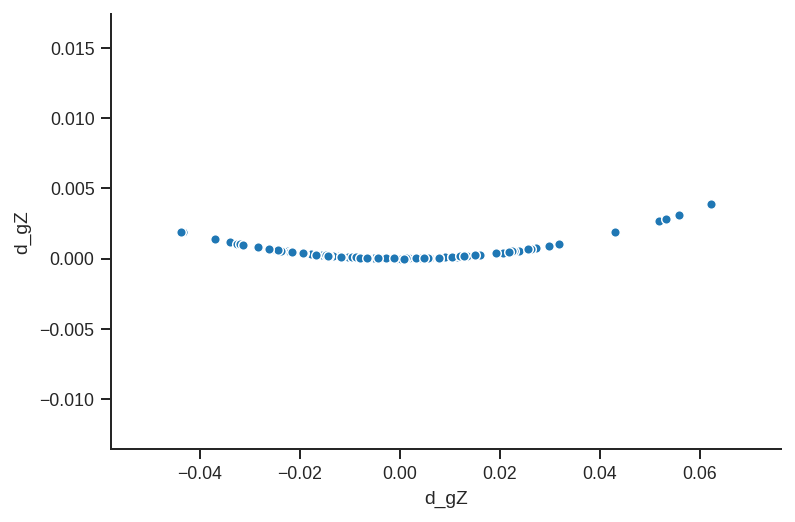

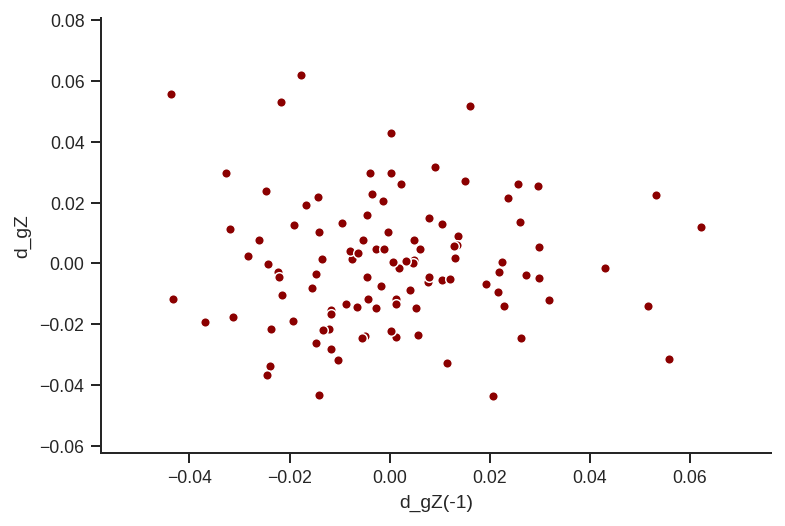

In [36]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

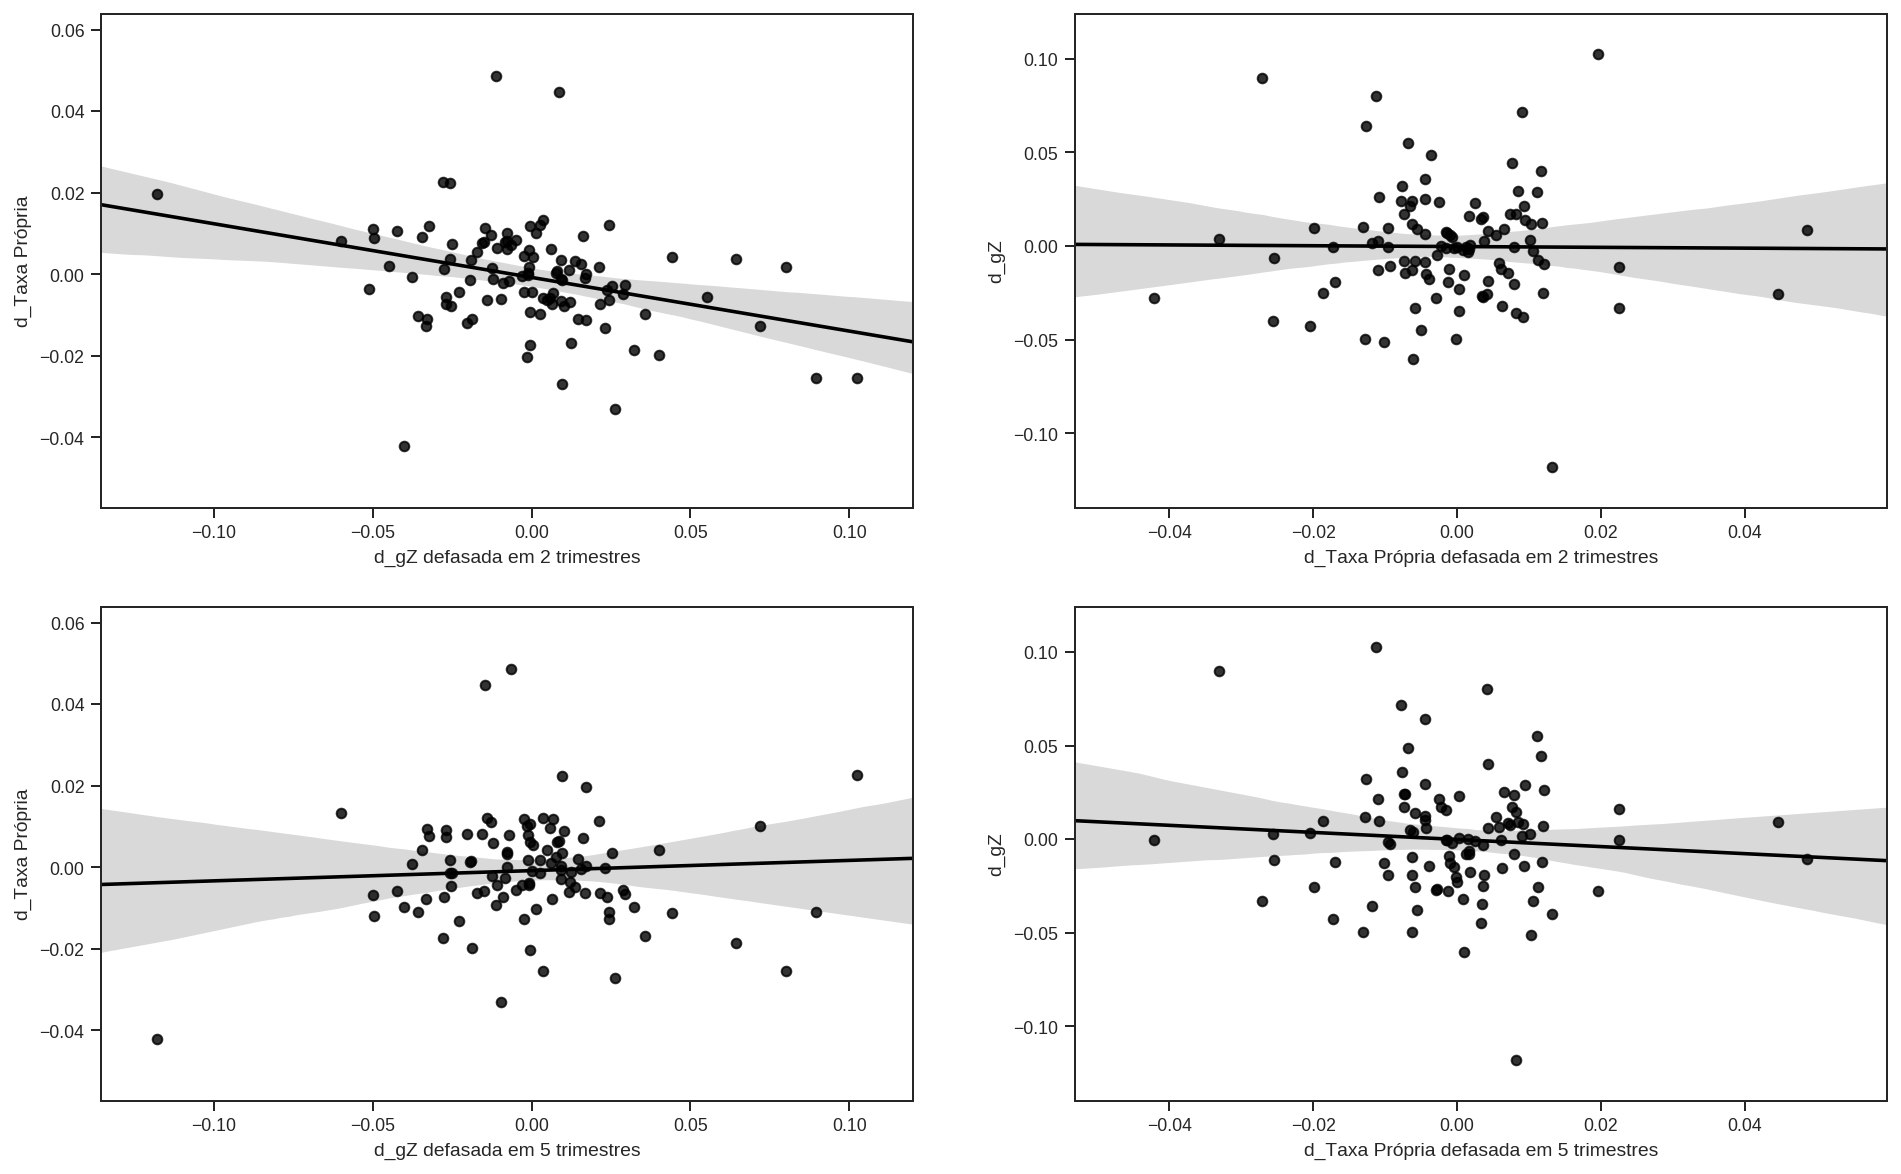

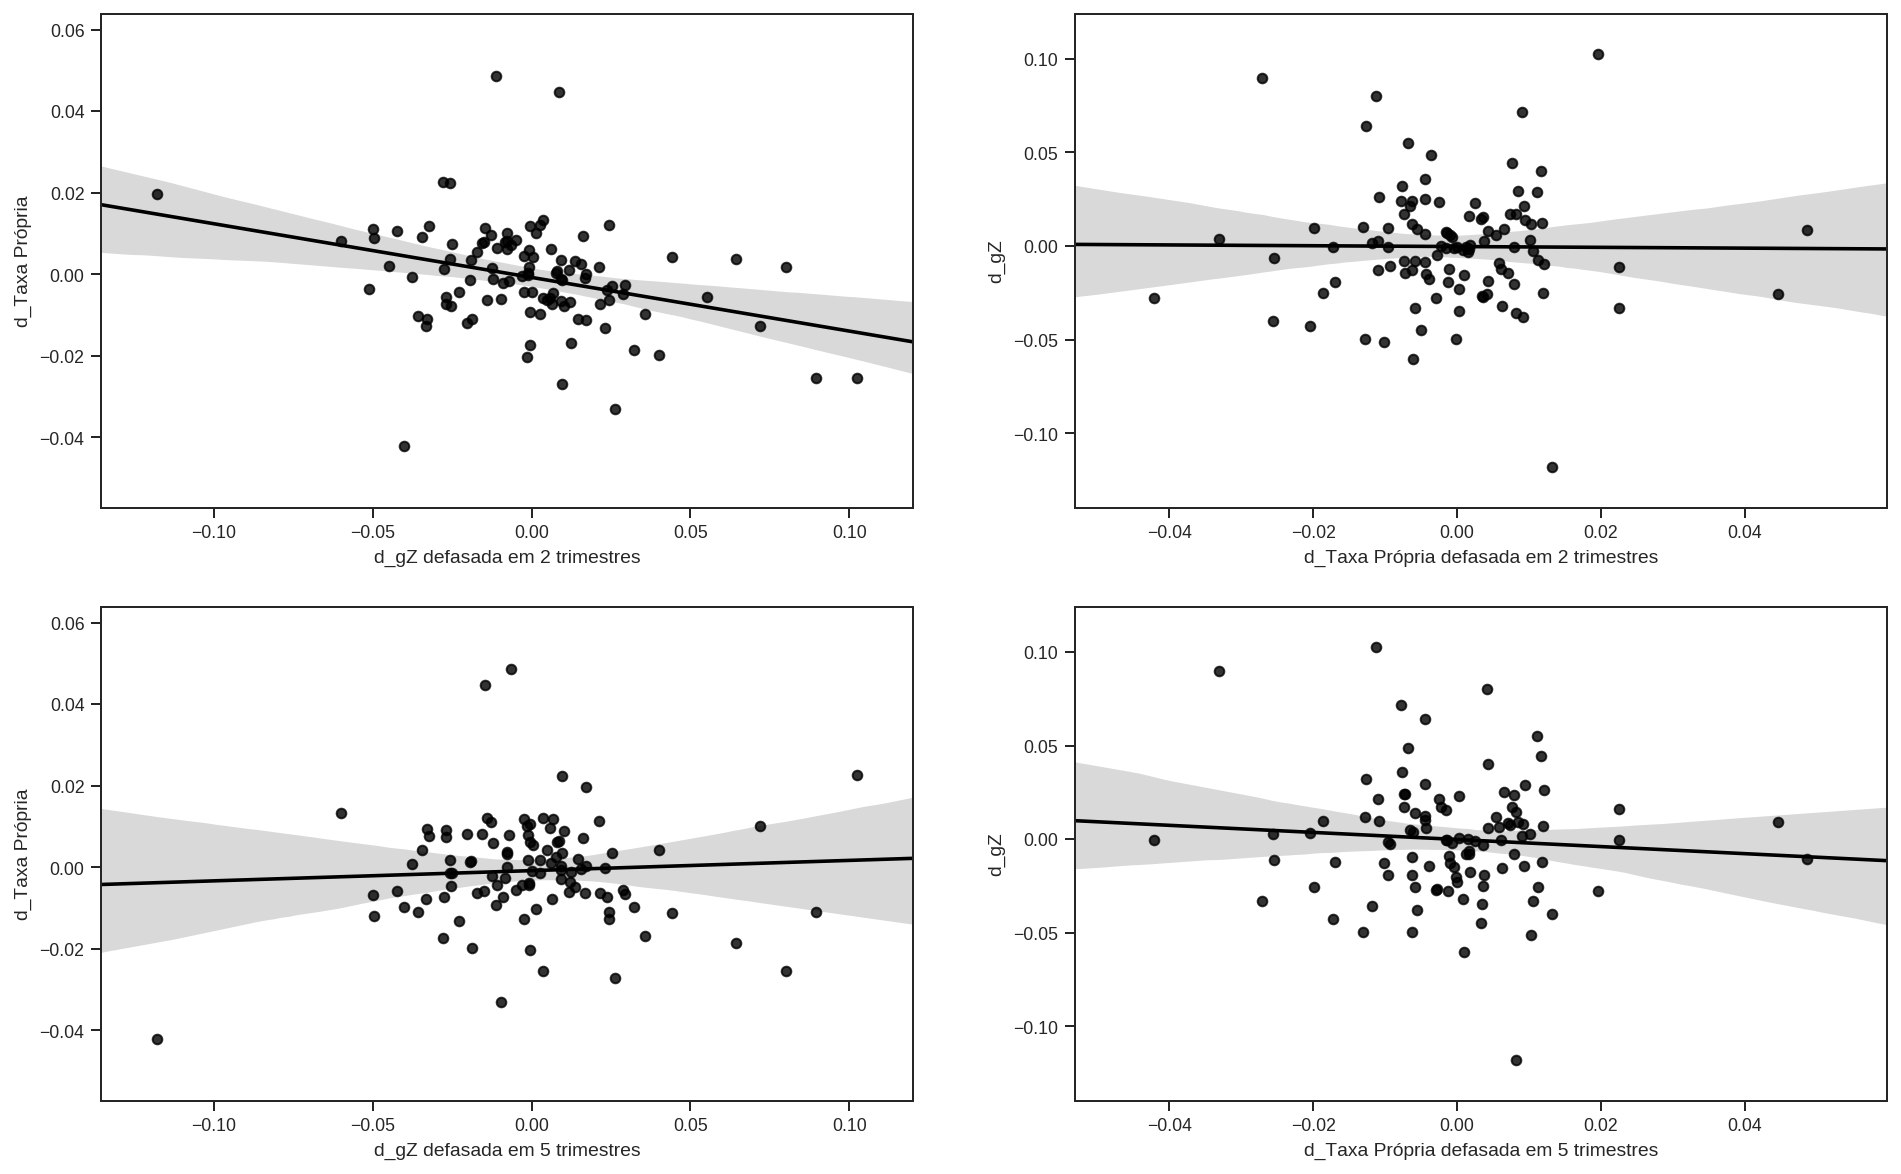

In [37]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

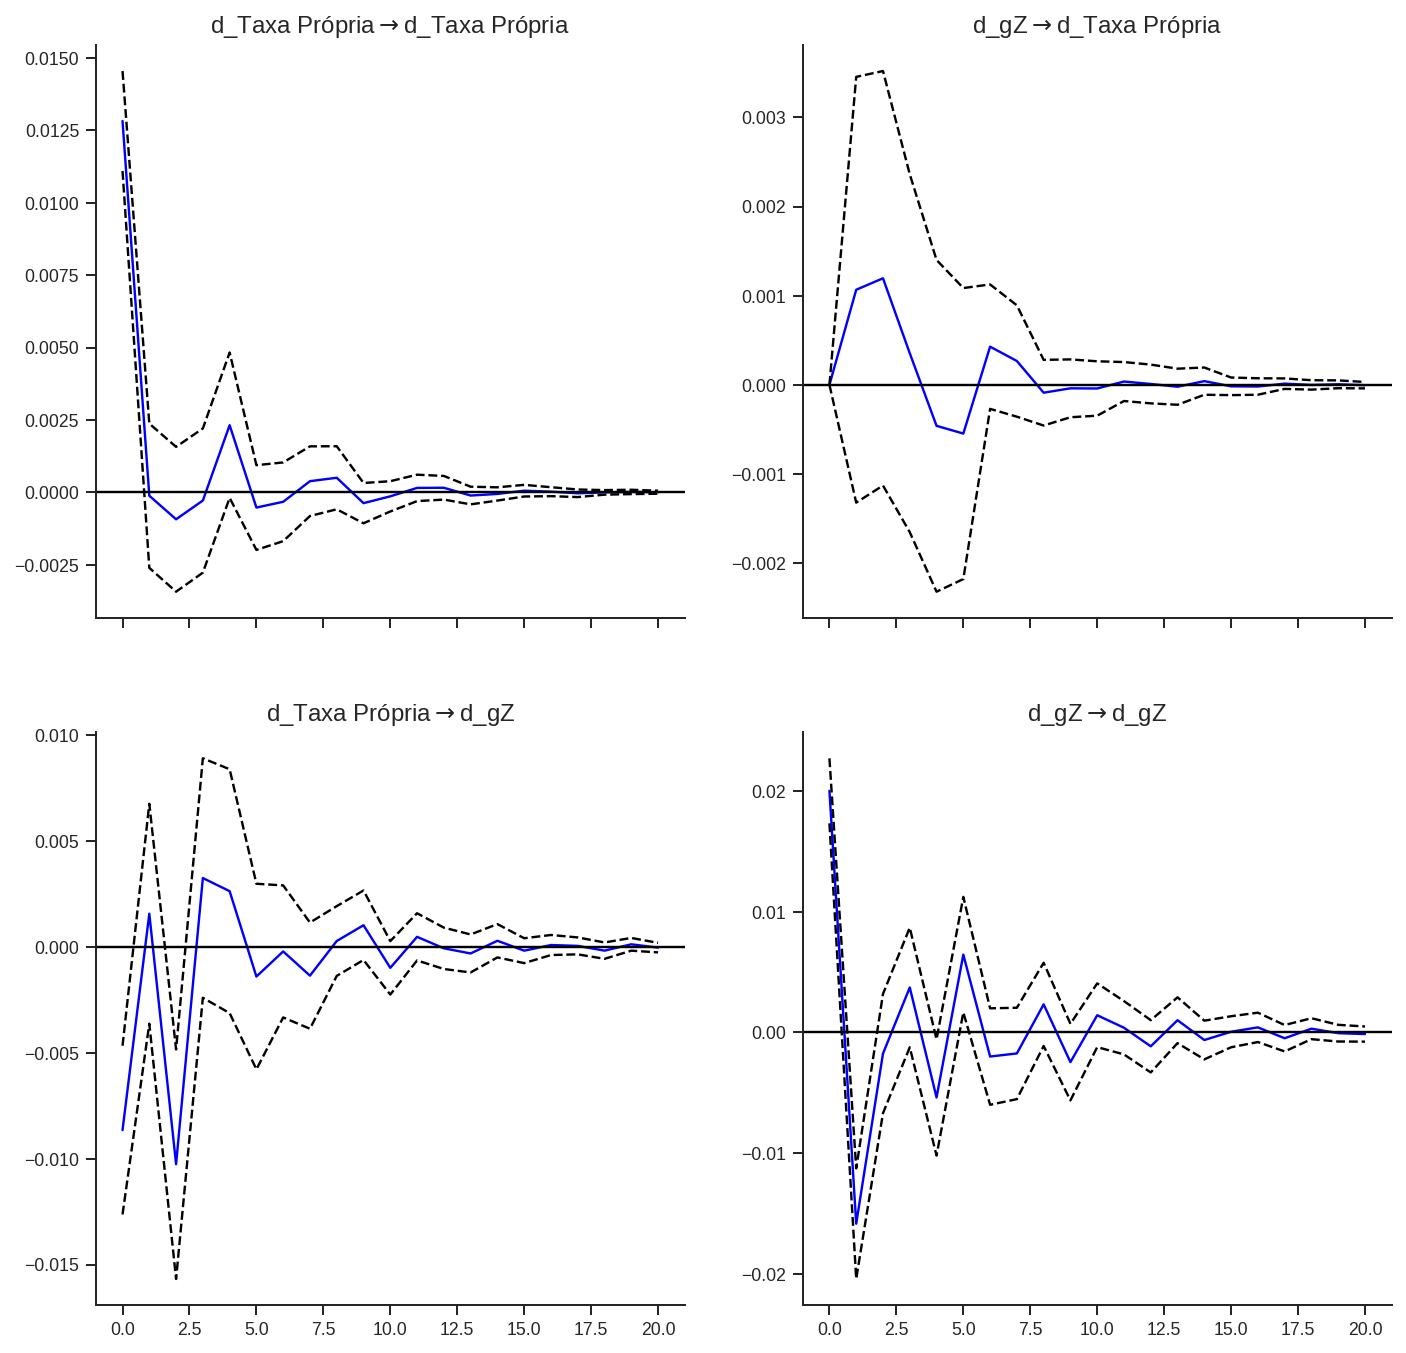

In [38]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

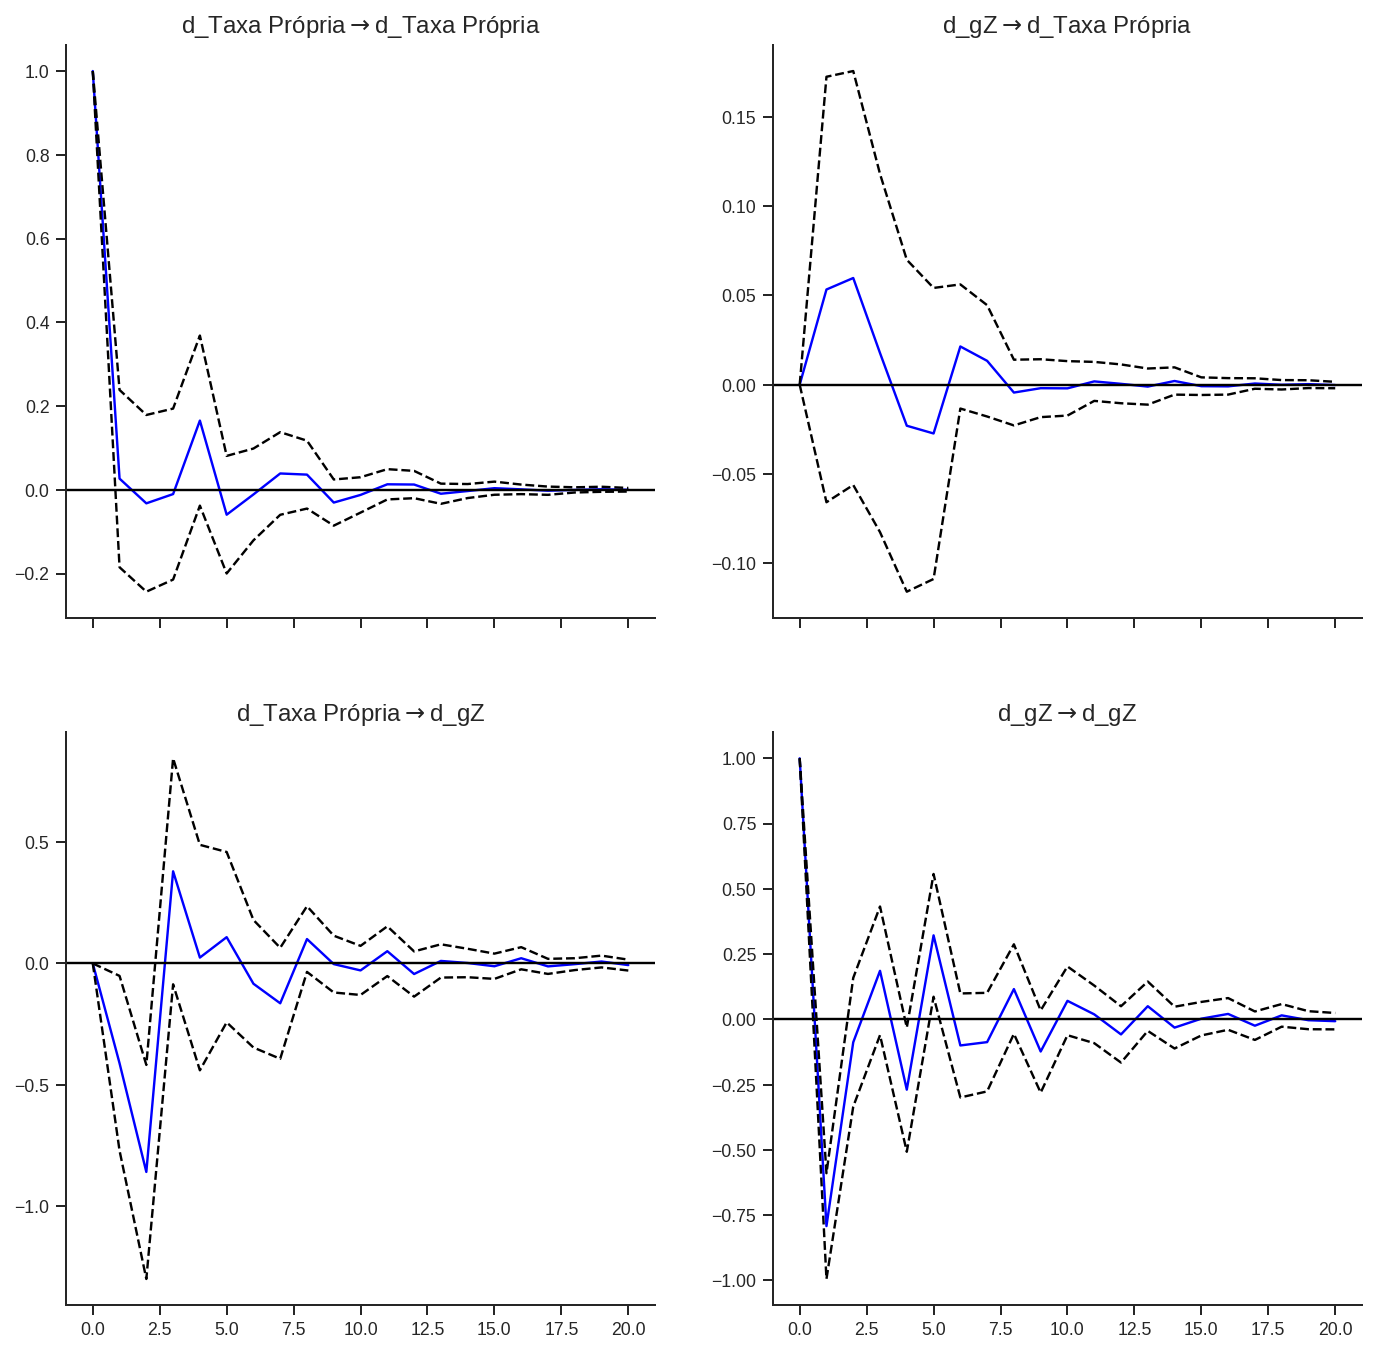

In [39]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

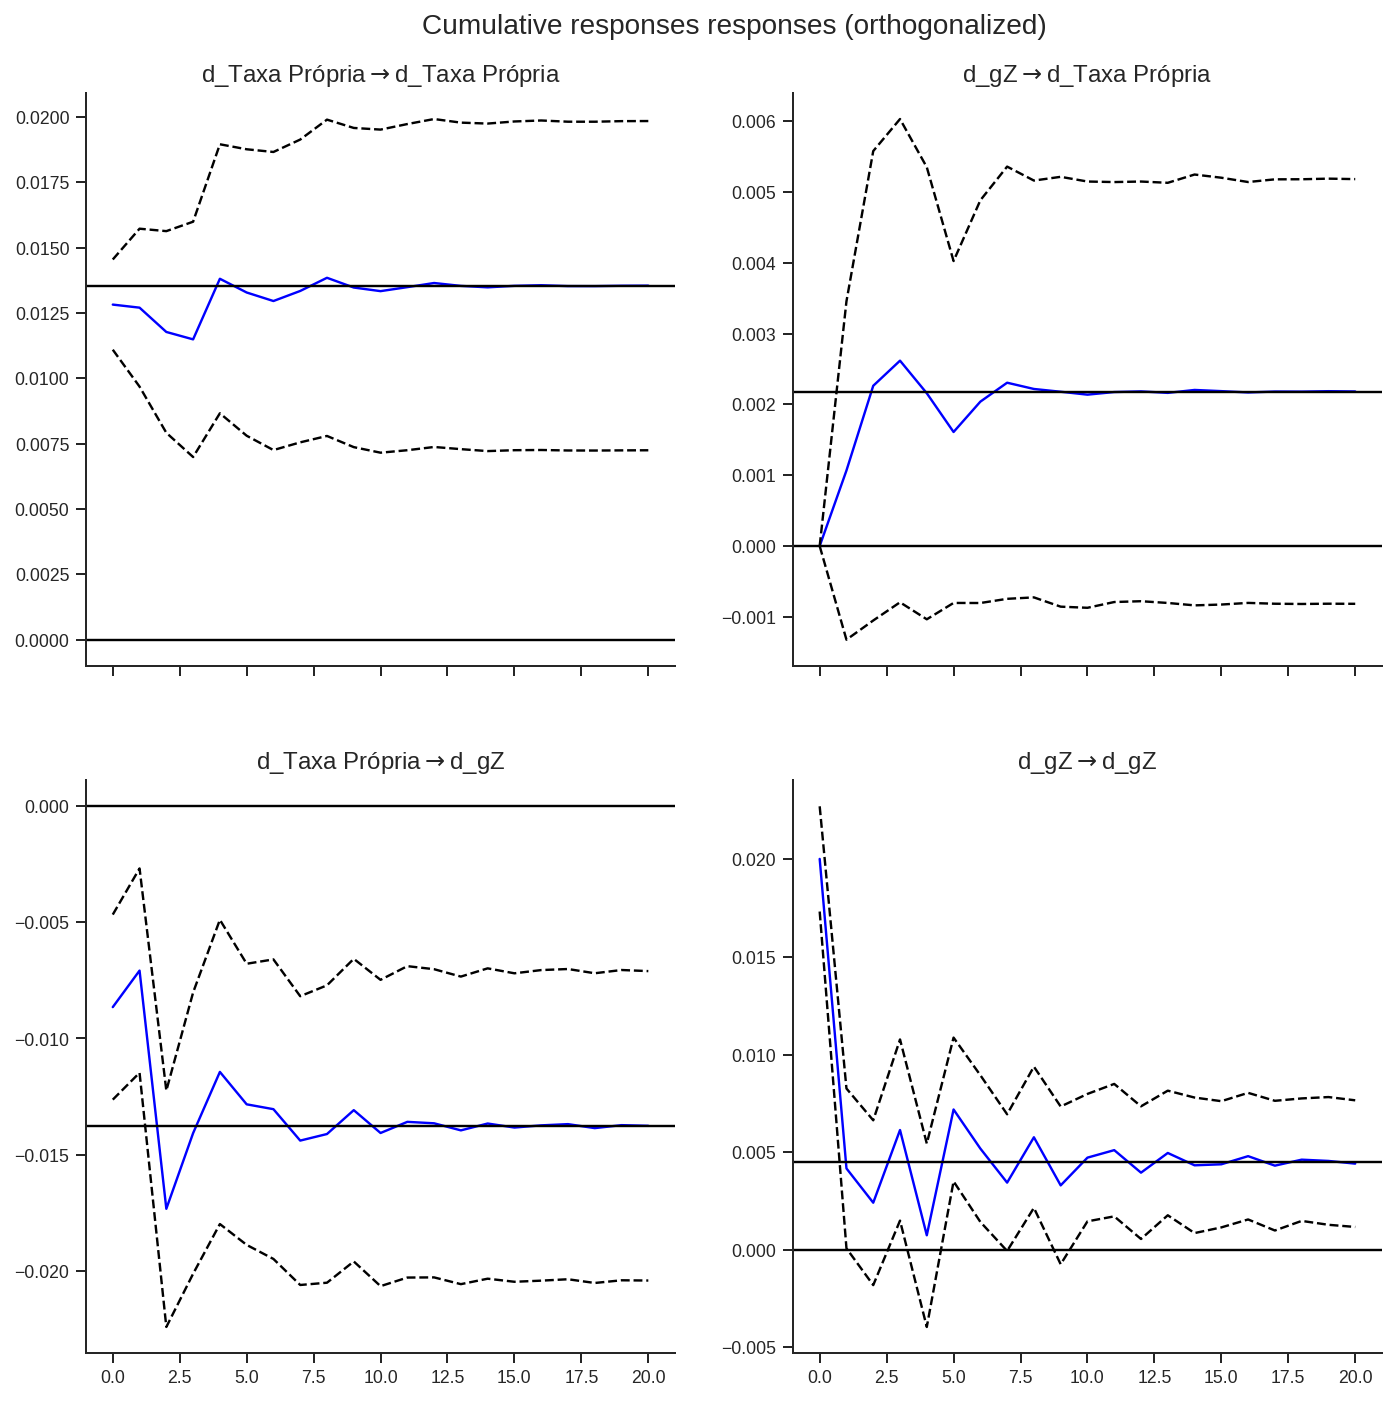

In [40]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

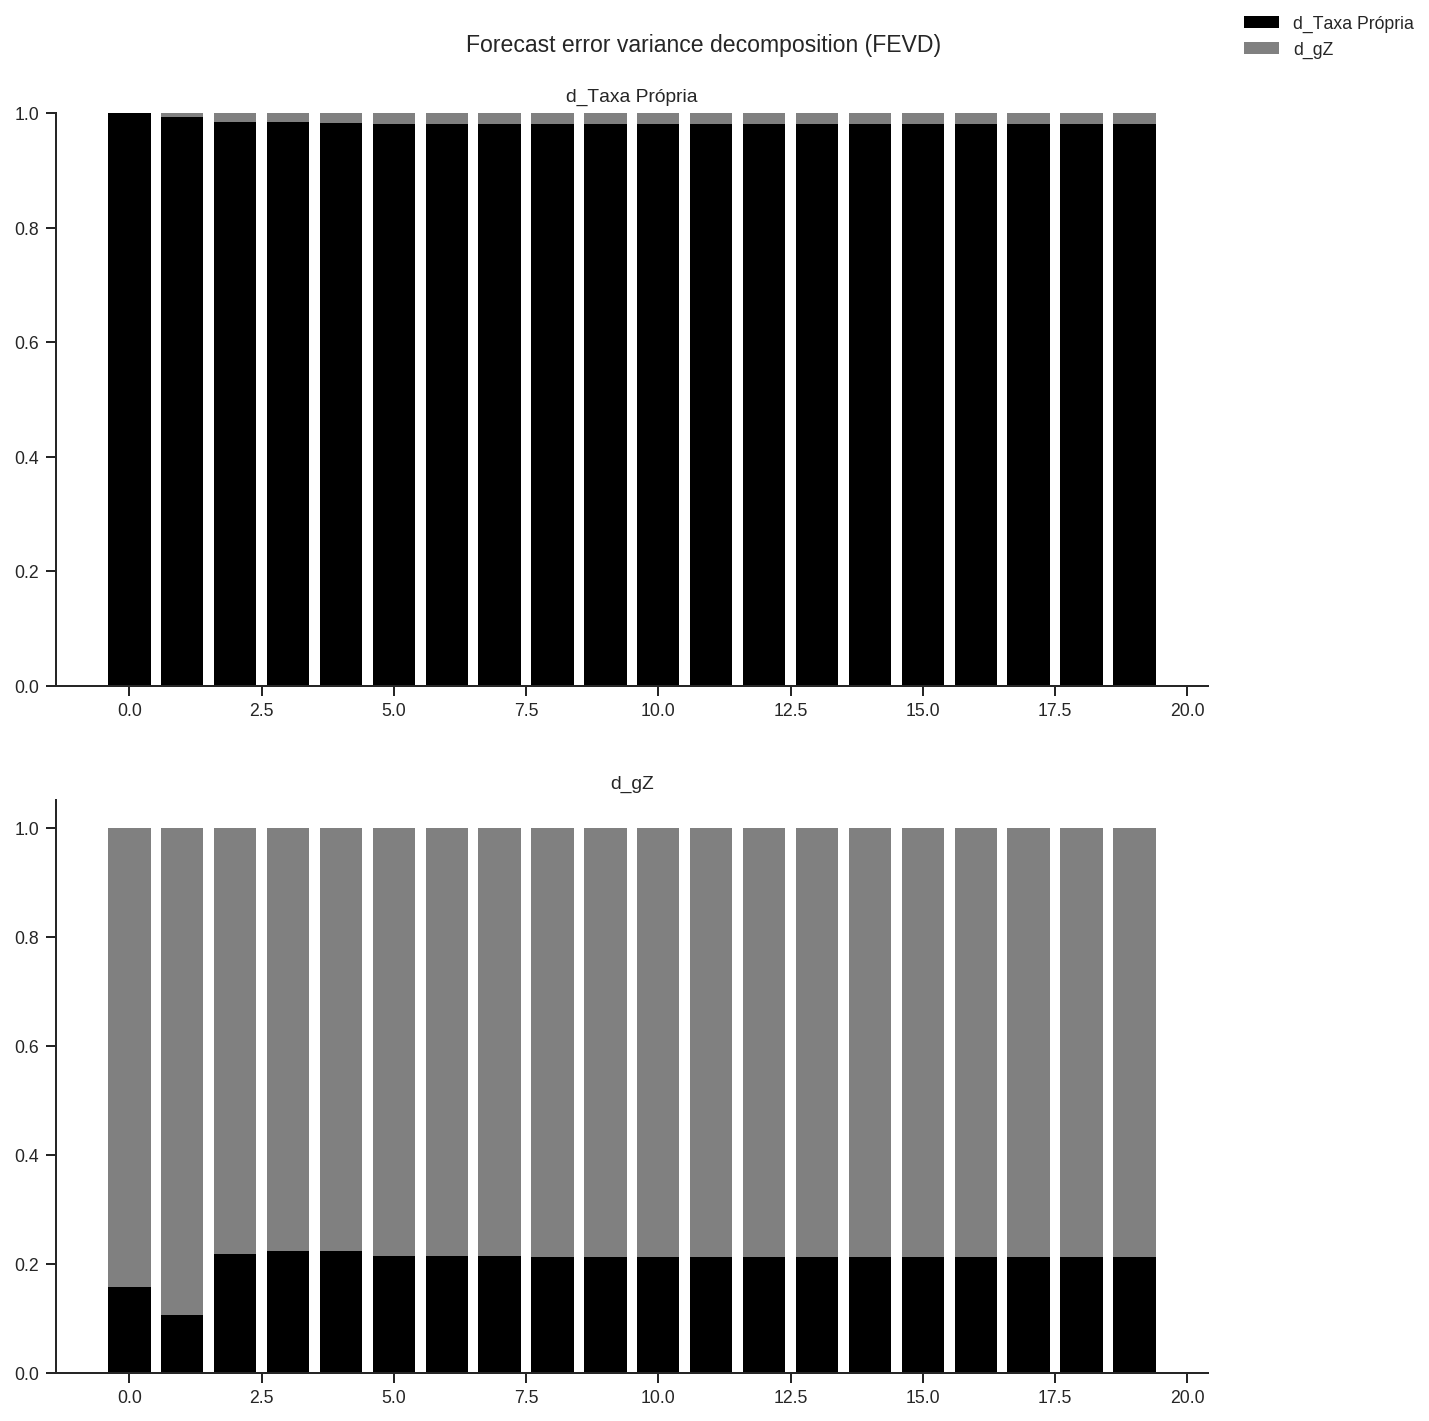

In [41]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)